# Masking the Data
Placing a limit on the frequency may help you achieve an optimal result in the fitting process.

Even on a good dataset, we can get a sizable error if we take into consideration every single frequency of data. This is because there can be some data that is considered an outlier. Take for example, 'DE_40_1_30.mpt' which by all accounts, is a good dataset without any unusual spikes or drops in the data. Let's take a look at if we were to import all frequencies in the file.

In [418]:
#Locate the data, prepare for import of the MPT file
#Import necessary packaging
from utils.tools import *
path=r"C:\Users\cjang\Desktop\impedance_data\data\\"
data = ['DE_40_14_60.mpt']
ex_mpt = mpt_data(path,data)

No handles with labels found to put in legend.


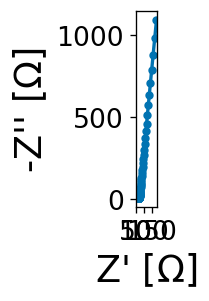

In [419]:
ex_mpt.mpt_plot()

If we take the guessing iterator and run it on this dataset, the guessing iterator has to find a fitting equation that satisfies every single point on this set, or something that is close.

Because the iterator cut out at 1000 iterations and return the set of coefficients at that state, we cannot say with full confidence that this is the best fit because it didn't necessarily satisfy the threshold. If we graph this 'optimal' set of coefficients, we aren't guaranteed a great fitting graph...

What we can do is eliminate some of the frequencies from the file to make it easier to get a more accurate graph. But how do we determine which frequencies to drop from the file? 

# Linear Kramer Kronig Analysis

The Linear Kramer Kronig Analysis determines the causality, linearity, and stability of the dataset. It'll help you determine a mask by examining the residual graph. Running the function ex_mpt.LinKK() will allow you to see where your residuals are fluctuating the most. From here you can determine on your own what your boundaries should be.

cycle || No. RC-elements ||   u
[1]            8            0.84


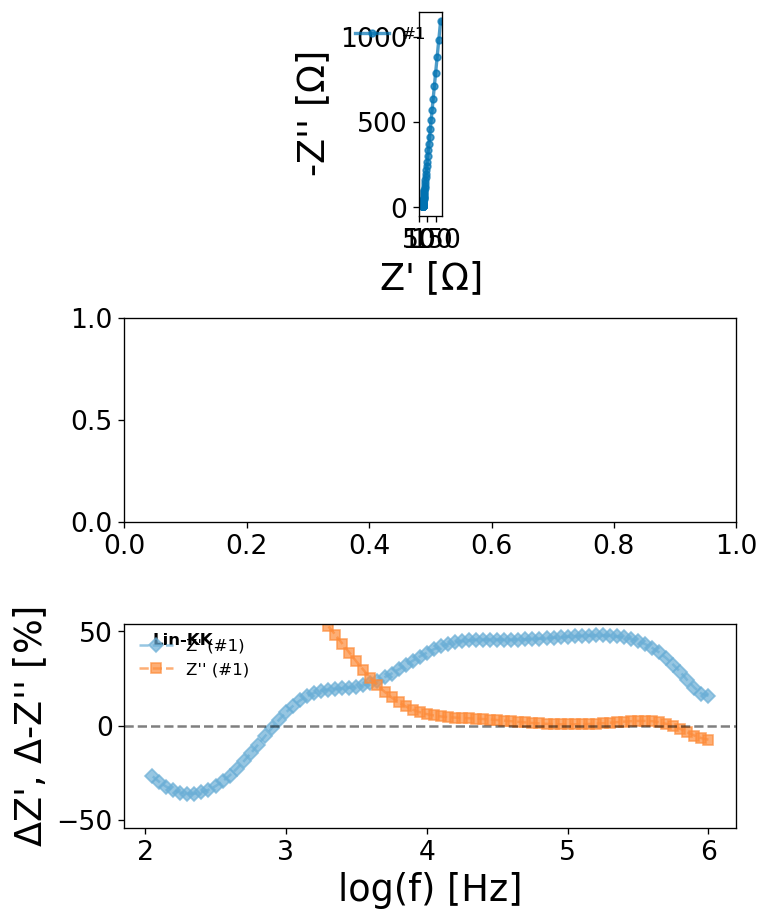

In [420]:
#Will be updated
ex_mpt.Lin_KK(plot = 'w_data')

cycle || No. RC-elements ||   u
[1]            8            0.84


C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate t

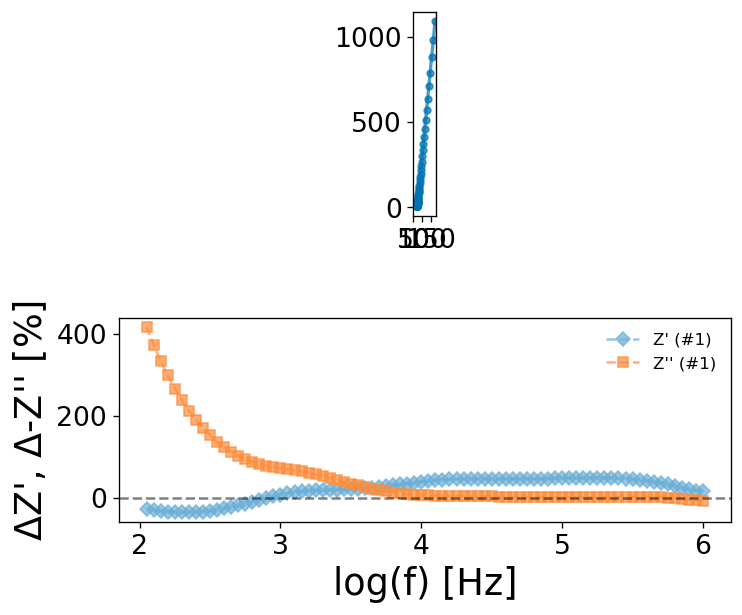

In [421]:
num_RC='auto' 
legend='on'
plot='residuals'
bode='off'
nyq_xlim='none'
nyq_ylim='none'
weight_func='Boukamp'



print('cycle || No. RC-elements ||   u')
ex_mpt.decade = []
ex_mpt.Rparam = []
ex_mpt.t_const = []
ex_mpt.Lin_KK_Fit = []
ex_mpt.R_names = []
ex_mpt.KK_R0 = []
ex_mpt.KK_R = []
ex_mpt.number_RC = []
ex_mpt.number_RC_sort = []

ex_mpt.KK_u = []
ex_mpt.KK_Rgreater = []
ex_mpt.KK_Rminor = []
M = 2
for i in range(len(ex_mpt.df)):
    ex_mpt.decade.append(np.log10(np.max(ex_mpt.df[i].f))-np.log10(np.min(ex_mpt.df[i].f))) #determine the number of RC circuits based on the number of decades measured and num_RC
    ex_mpt.number_RC.append(M)
    ex_mpt.number_RC_sort.append(M) #needed for ex_mpt.KK_R
    ex_mpt.Rparam.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0]) #Creates intial guesses for R's
    ex_mpt.t_const.append(KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i]))) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits

    ex_mpt.Lin_KK_Fit.append(minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) )) #maxfev=99
    ex_mpt.R_names.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1]) #creates R names
    for j in range(len(ex_mpt.R_names[i])):
        ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[i].params.get(ex_mpt.R_names[i][j]).value)
ex_mpt.number_RC_sort.insert(0,0) #needed for ex_mpt.KK_R
for i in range(len(ex_mpt.df)):
    ex_mpt.KK_R.append(ex_mpt.KK_R0[int(np.cumsum(ex_mpt.number_RC_sort)[i]):int(np.cumsum(ex_mpt.number_RC_sort)[i+1])]) #assigns resistances from each spectra to their respective df
    ex_mpt.KK_Rgreater.append(np.where(np.array(ex_mpt.KK_R)[i] >= 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_Rminor.append(np.where(np.array(ex_mpt.KK_R)[i] < 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_u.append(1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i]))))

for i in range(len(ex_mpt.df)):
    while ex_mpt.KK_u[i] <= 0.75 or ex_mpt.KK_u[i] >= 0.88:
        ex_mpt.number_RC_sort0 = []
        ex_mpt.KK_R_lim = []
        ex_mpt.number_RC[i] = ex_mpt.number_RC[i] + 1
        ex_mpt.number_RC_sort0.append(ex_mpt.number_RC)
        ex_mpt.number_RC_sort = np.insert(ex_mpt.number_RC_sort0, 0,0)
        ex_mpt.Rparam[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0] #Creates intial guesses for R's
        ex_mpt.t_const[i] = KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i])) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits
        ex_mpt.Lin_KK_Fit[i] = minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) ) #maxfev=99
        ex_mpt.R_names[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1] #creates R names
        ex_mpt.KK_R0 = np.delete(np.array(ex_mpt.KK_R0), np.s_[0:len(ex_mpt.KK_R0)])
        ex_mpt.KK_R0 = []
        for q in range(len(ex_mpt.df)):
            for j in range(len(ex_mpt.R_names[q])):
                ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[q].params.get(ex_mpt.R_names[q][j]).value)
        ex_mpt.KK_R_lim = np.cumsum(ex_mpt.number_RC_sort) #used for KK_R[i]

        ex_mpt.KK_R[i] = ex_mpt.KK_R0[ex_mpt.KK_R_lim[i]:ex_mpt.KK_R_lim[i+1]] #assigns resistances from each spectra to their respective df
        ex_mpt.KK_Rgreater[i] = np.where(np.array(ex_mpt.KK_R[i]) >= 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_Rminor[i] = np.where(np.array(ex_mpt.KK_R[i]) < 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_u[i] = 1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i])))
    else:
        print('['+str(i+1)+']'+'            '+str(ex_mpt.number_RC[i]),'           '+str(np.round(ex_mpt.KK_u[i],2)))

ex_mpt.KK_circuit_fit = []
ex_mpt.KK_rr_re = []
ex_mpt.KK_rr_im = []
functs = []
for i in range(2,81):
    functs.append('KK_RC'+str(i))

for i in range(len(ex_mpt.df)):
    cir_num = int(ex_mpt.number_RC[i])
    cir_funct = eval(functs[cir_num - 2])
    ex_mpt.KK_circuit_fit.append(cir_funct(w=ex_mpt.df[0].w, Rs=ex_mpt.Lin_KK_Fit[0].params.get('Rs').value, R_values=ex_mpt.KK_R[0], t_values=ex_mpt.t_const[0]))
    if cir_num >= 81:
        print('RC simulation circuit not defined')
        print('   Number of RC = ', ex_mpt.number_RC)
    ex_mpt.KK_rr_re.append(residual_real(re=ex_mpt.df[i].re, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the real part
    ex_mpt.KK_rr_im.append(residual_imag(im=ex_mpt.df[i].im, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the imag part
    
    


   
    fig = figure(figsize=(6, 8), dpi=120, facecolor='w', edgecolor='k')
    fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
    ax = fig.add_subplot(311, aspect='equal')
    ax1 = fig.add_subplot(312)

    colors = sns.color_palette("colorblind", n_colors=len(ex_mpt.df))
    colors_real = sns.color_palette("Blues", n_colors=len(ex_mpt.df)+2)
    colors_imag = sns.color_palette("Oranges", n_colors=len(ex_mpt.df)+2)

    ### Nyquist Plot
    for i in range(len(ex_mpt.df)):
        ax.plot(ex_mpt.df[i].re, ex_mpt.df[i].im, marker='o', ms=4, lw=2, color=colors[i], ls='-', alpha=.7, label=ex_mpt.label_cycleno[i])


    ### Kramers-Kronig Relative Residuals    
    for i in range(len(ex_mpt.df)):
        ax1.plot(np.log10(ex_mpt.df[i].f), ex_mpt.KK_rr_re[i]*100, color=colors_real[i+1], marker='D', ls='--', ms=6, alpha=.7, label=ex_mpt.label_re_1[i])
        ax1.plot(np.log10(ex_mpt.df[i].f), ex_mpt.KK_rr_im[i]*100, color=colors_imag[i+1], marker='s', ls='--', ms=6, alpha=.7, label=ex_mpt.label_im_1[i])
        ax1.set_xlabel("log(f) [Hz]")
        ax1.set_ylabel("$\Delta$Z', $\Delta$-Z'' [%]")
        if legend == 'on' or legend == 'potential': 
            ax1.legend(loc='best', fontsize=10, frameon=False)        
    ax1.axhline(0, ls='--', c='k', alpha=.5)








kk_df = pd.DataFrame({'f':np.log10(ex_mpt.df_raw.f), 're':ex_mpt.KK_rr_re[0]*100, 'im':ex_mpt.KK_rr_im[0]*100})

In [222]:
re_avg, im_avg  = mean(kk_df['re']), mean(kk_df['im'])
re_avg, im_avg 

(2.2825800211085716, 63.59206554073585)

In [235]:
z = kk_df[abs(kk_df['re']) <= re_avg * 1]
y = kk_df[abs(kk_df['im']) <= im_avg * 1]
x = pd.concat([z, y]).drop_duplicates()
10**(x['f'].max()), 10**(x['f'].min())

(1000018.6000000008, 8.9183798)

In [301]:
skeleton = ex_mpt.df_raw.iloc[:,0:3]
skeleton

,f,re,im
0,1.000019e+06,5.588623,-21.543896
1,8.912467e+05,49.979565,10.023279
2,7.943327e+05,50.685020,9.019663
3,7.079498e+05,52.225689,8.011496
4,6.309568e+05,53.448158,7.306321
...,...,...,...
78,1.258457e+02,139.080260,933.572390
79,1.121900e+02,147.544860,1041.340200
80,1.000320e+02,157.284290,1161.372100
81,8.911597e+01,168.440060,1296.273900


,f,re,im
0,1.000019e+06,5.588623,-21.543896
1,8.912467e+05,49.979565,10.023279
2,7.943327e+05,50.685020,9.019663
3,7.079498e+05,52.225689,8.011496
4,6.309568e+05,53.448158,7.306321
...,...,...,...
78,1.258457e+02,139.080260,933.572390
79,1.121900e+02,147.544860,1041.340200
80,1.000320e+02,157.284290,1161.372100
81,8.911597e+01,168.440060,1296.273900


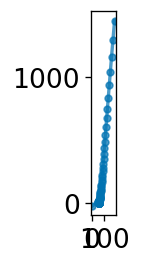

In [375]:
re_mid, im_mid  = mean(skeleton['re']), mean(skeleton['im'])
a = skeleton[abs(skeleton['re']) <= re_avg * .2]
b = skeleton[abs(skeleton['im']) <= im_avg * .2]
c = pd.concat([a, b]).drop_duplicates()


fig = figure(figsize=(6, 8), dpi=120, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
ax = fig.add_subplot(311, aspect='equal')


### Nyquist Plot
ax.plot(c['re'], c['im'], marker='o', ms=4, lw=2, color=colors[i], ls='-', alpha=.7)
c

In [376]:
c['f'].max(), c['f'].min()

(1000018.6, 79.415527)

In [382]:
#Notice how the graph shows log(f) not f. We must translate back
#so instead of 1.75 and 6, we must insert 10**1.75 and 10**6
masked_mpt = mpt_data(path,data, mask = [10**5.5, 10**3.5])
#masked_mpt.guesser(Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2)

No handles with labels found to put in legend.


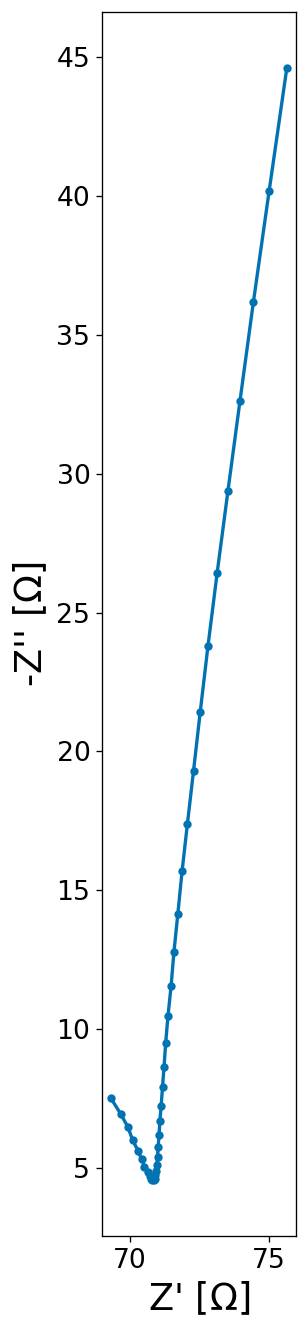

In [383]:
masked_mpt.set_new_gph_dims(30,30)
masked_mpt.mpt_plot()

# Automated Masker

The process above is ideal if all your fitting is a single mpt file. If we want to fit multiple files, or hundreds of files in a batch folder, we need a more automated process. We can call on ex_mpt.masker() to find the best window for us. 

Calling masker takes the average of the distance between the residuals and uses it as an additional threshold, so if the residual lands outside the threshold, all frequencies associated with that residual point will be omitted from the graph. We then run the guessing iterator and see if it achieves 1e-10 error within a thousand iterations. If it does not, we shrink the threshold by a factor of 0.9 to increase exclusivity. 


In [384]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func):
    if circuit == 'R-RQ-RQ':
        re_fit = cir_RsRQRQ_fit(params, w).real
        im_fit = -cir_RsRQRQ_fit(params, w).imag
    else:
        print('Circuit is not defined in leastsq_errorfunc()')
    
    error = [(re-re_fit)**2, (im-im_fit)**2] #sum of squares
    print('ERROR: ', sum(error))
    #Different Weighing options, see Lasia
    if weight_func == 'modulus':
        weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
    elif weight_func == 'proportional':
        weight = [1/(re_fit**2), 1/(im_fit**2)]
    elif weight_func == 'unity':
        unity_1s = []
        for k in range(len(re)):
            unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
        weight = [unity_1s, unity_1s]
    else:
        print('weight not defined in leastsq_errorfunc()')
        
    S = np.array(weight) * error #weighted sum of squares
    print('Weighted SUM OF SQUARES: ',sum(S)) 
    return sum(S)

In [385]:
import sys

def guesser(ex_mpt, Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2):
    
    params = Parameters()
    guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
    #adding to the parameters package to send to the fitting function
    params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=10**6)
    params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=10**6)
    params.add('n', value=guess_package[2], min=.65, max=1)
    params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
    params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=10**6)
    params.add('n2', value=guess_package[5], min=.65, max=1)
    params.add('fs2', value=guess_package[6], min=10**-2, max=10**6)
    ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

    counter = 0

    
    
    
    while ex_mpt.low_error >= 100 and counter <= 1000:
        
        try:
            counter += 1
            print('ITERATION NO. : ', counter)
            Rs_guess = ex_mpt.fit_Rs[0]

            R_guess = ex_mpt.fit_R[0]
            n_guess = ex_mpt.fit_n[0]
            fs_guess = ex_mpt.fit_fs[0]

            R2_guess = ex_mpt.fit_R2[0]
            n2_guess = ex_mpt.fit_n2[0]
            fs2_guess = ex_mpt.fit_fs2[0]

            guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
            #adding to the parameters package to send to the fitting function
            params = Parameters()
            params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
            params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
            params.add('n', value=guess_package[2], min=.65, max=1)
            params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
            params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
            params.add('n2', value=guess_package[5], min=.65, max=1)
            params.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
            ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

       
        except KeyboardInterrupt:
            print('Interrupted!!')
            print([ex_mpt.fit_Rs[0],ex_mpt.fit_R[0],ex_mpt.fit_n[0],ex_mpt.fit_Q[0],ex_mpt.fit_R2[0],ex_mpt.fit_n2[0],ex_mpt.fit_Q2[0]])
            
        
    ex_mpt.mpt_plot(fitting = 'on')

ERROR:  205100.19234230358
ERROR:  205100.19234230358
ERROR:  205100.19234230358
ERROR:  205100.06437010173
ERROR:  205100.19226385056
ERROR:  205100.1923423167
ERROR:  205100.19234230352
ERROR:  205100.19233369903
ERROR:  205100.1923423055
ERROR:  205100.19232647587
ERROR:  1623981174888.7725
ERROR:  38268246718170.96
ERROR:  38206651582152.64
ERROR:  5346251678834.149
ERROR:  4461084959709.597
ERROR:  514457315.3468721
ERROR:  514457319.4368044
ERROR:  514457371.1429166
ERROR:  514457315.3652508
ERROR:  514457809.1184539
ERROR:  514457499.0776481
ERROR:  514457278.61999834
ERROR:  514457481.18041945
ERROR:  368218495.7678659
ERROR:  368218499.0435728
ERROR:  368218522.6445695
ERROR:  368218495.7759486
ERROR:  368218597.5259089
ERROR:  368218637.0664221
ERROR:  368218461.14897
ERROR:  368218629.84644526
ERROR:  177220154.9286723
ERROR:  177220157.00636995
ERROR:  177220160.60847345
ERROR:  177220154.92861402
ERROR:  177220162.3395249
ERROR:  177220232.8351555
ERROR:  177220126.6763484

ERROR:  853.6028959076384
ERROR:  853.5754884588957
ERROR:  853.605507378855
ERROR:  853.6055014774365
ERROR:  853.6057579270407
ERROR:  853.6056466815539
ERROR:  853.6058357973004
ERROR:  852.9713092282105
ERROR:  852.9687047001096
ERROR:  852.941289124308
ERROR:  852.9713020104706
ERROR:  852.9713102111407
ERROR:  852.9715357173806
ERROR:  852.9714657041558
ERROR:  852.9715920448288
ERROR:  852.4003807086547
ERROR:  852.3977759324903
ERROR:  852.370352403184
ERROR:  852.4003879253258
ERROR:  852.4003814569212
ERROR:  852.4005762301769
ERROR:  852.4005470662868
ERROR:  852.4006111742528
ERROR:  851.8914576072466
ERROR:  851.888852584226
ERROR:  851.8614212943103
ERROR:  851.8914503878286
ERROR:  851.8914581769543
ERROR:  851.8916224320446
ERROR:  851.8916337521983
ERROR:  851.8916361437338
ERROR:  851.4433084077197
ERROR:  851.4407031600131
ERROR:  851.4132642806517
ERROR:  851.4433156039759
ERROR:  851.4433088415428
ERROR:  851.4434427958928
ERROR:  851.4434942492443
ERROR:  851.4434

ITERATION NO. :  2
ERROR:  1553.331093610024
ERROR:  1553.331093610024
ERROR:  1553.331093610024
ERROR:  1553.3312794736655
ERROR:  1553.331499182809
ERROR:  1553.3310934390604
ERROR:  1553.3310900153563
ERROR:  1553.3310397067955
ERROR:  1553.3310946405866
ERROR:  1553.3310924267205
ERROR:  23790.400209277574
ERROR:  18190.622745301902
ERROR:  1517.5052682992273
ERROR:  1517.5054569064175
ERROR:  1517.5056757055036
ERROR:  1517.5052682450773
ERROR:  1517.5052701876305
ERROR:  1517.5052165088898
ERROR:  1517.50526911167
ERROR:  1517.5052679730247
ERROR:  1484.1196795807634
ERROR:  1484.1198679785368
ERROR:  1484.1200849771994
ERROR:  1484.1196794386303
ERROR:  1484.1196772883623
ERROR:  1484.119629696472
ERROR:  1484.1196802309291
ERROR:  1484.1196796048418
ERROR:  1453.460012106393
ERROR:  1453.4601995239577
ERROR:  1453.4604144046789
ERROR:  1453.4600117863379
ERROR:  1453.4600149686528
ERROR:  1453.459963555467
ERROR:  1453.4600126606413
ERROR:  1453.4600121089195
ERROR:  1423.14073

ERROR:  670.0749820458009
ERROR:  670.0749808202129
ERROR:  664.5130435160518
ERROR:  664.5130816340711
ERROR:  664.5131724912394
ERROR:  664.5130408646595
ERROR:  664.5130424311078
ERROR:  664.5130099485943
ERROR:  664.5130447520056
ERROR:  664.5130435160518
ERROR:  659.2585189248344
ERROR:  659.2585537628341
ERROR:  659.258642720163
ERROR:  659.2585163402043
ERROR:  659.2585200954753
ERROR:  659.258485558946
ERROR:  659.2585201708738
ERROR:  659.2585189248344
ERROR:  654.2953097914925
ERROR:  654.2953414278932
ERROR:  654.2954285512122
ERROR:  654.2953072746234
ERROR:  654.29530869682
ERROR:  654.2952766217068
ERROR:  654.2953110472839
ERROR:  654.2953097914925
ERROR:  649.600971423779
ERROR:  649.6009999630088
ERROR:  649.6010853271871
ERROR:  649.600968975085
ERROR:  649.6009726120866
ERROR:  649.6009384430356
ERROR:  649.6009726889961
ERROR:  649.600971423779
ERROR:  645.159051278593
ERROR:  645.1590768187635
ERROR:  645.1591604950764
ERROR:  645.1590488983835
ERROR:  645.15905017

ERROR:  549.543678590279
ERROR:  547.926048697006
ERROR:  547.926026936033
ERROR:  547.9260853207152
ERROR:  547.9260482679571
ERROR:  547.926049301116
ERROR:  547.9260202875765
ERROR:  547.9260500571254
ERROR:  547.926048697006
ERROR:  546.3126145990595
ERROR:  546.3125929038187
ERROR:  546.3126512594191
ERROR:  546.3126141891179
ERROR:  546.3126140226535
ERROR:  546.3125862597728
ERROR:  546.3126159559077
ERROR:  546.3126145990595
ERROR:  544.7029607969907
ERROR:  544.702939190669
ERROR:  544.7029975244849
ERROR:  544.7029604053455
ERROR:  544.7029613973771
ERROR:  544.702932527191
ERROR:  544.7029621504826
ERROR:  544.7029607969907
ERROR:  543.0967147961643
ERROR:  543.0966933004895
ERROR:  543.0967516191135
ERROR:  543.0967144220346
ERROR:  543.0967142233548
ERROR:  543.0966865952286
ERROR:  543.0967161462223
ERROR:  543.0967147961643
ERROR:  541.4935362768259
ERROR:  541.4935149121319
ERROR:  541.4935732214961
ERROR:  541.4935359194592
ERROR:  541.4935368733476
ERROR:  541.4935081

ERROR:  486.07349960396505
ERROR:  486.0734983968348
ERROR:  484.49437941997945
ERROR:  484.49436894637967
ERROR:  484.49442772787916
ERROR:  484.49437935334896
ERROR:  484.49437993842037
ERROR:  484.49435353377623
ERROR:  484.4943806230789
ERROR:  484.49437941997945
ERROR:  482.9152056094599
ERROR:  482.9151954908385
ERROR:  482.9152542641687
ERROR:  482.915205545888
ERROR:  482.9152051143444
ERROR:  482.9151797829397
ERROR:  482.91520680853523
ERROR:  482.9152056094599
ERROR:  481.3359706030508
ERROR:  481.33596083884606
ERROR:  481.3360196019119
ERROR:  481.3359705423963
ERROR:  481.3359711170485
ERROR:  481.33594483616423
ERROR:  481.3359717981112
ERROR:  481.3359706030508
ERROR:  479.7566772977041
ERROR:  479.7566678872324
ERROR:  479.75672663792824
ERROR:  479.75667723983383
ERROR:  479.75667680678566
ERROR:  479.7566515904056
ERROR:  479.7566784887596
ERROR:  479.7566772977041
ERROR:  478.17732484334084
ERROR:  478.1773157858048
ERROR:  478.17737452201084
ERROR:  478.17732478812

ERROR:  419.7730321037632
ERROR:  419.7730090606378
ERROR:  419.77303356264
ERROR:  419.77303251628183
ERROR:  418.1984637933109
ERROR:  418.1984669439612
ERROR:  418.1985236243596
ERROR:  418.1984637840448
ERROR:  418.19846422013535
ERROR:  418.1984403968678
ERROR:  418.1984648360668
ERROR:  418.1984637933109
ERROR:  416.6243000435907
ERROR:  416.6243034756729
ERROR:  416.62436006623295
ERROR:  416.62430003474896
ERROR:  416.62429963510743
ERROR:  416.6242767063522
ERROR:  416.6243010827538
ERROR:  416.6243000435907
ERROR:  415.05055913868057
ERROR:  415.0505628499657
ERROR:  415.05061934910117
ERROR:  415.050559130245
ERROR:  415.05055956125614
ERROR:  415.05053586065026
ERROR:  415.0505601742606
ERROR:  415.05055913868057
ERROR:  413.4772584863482
ERROR:  413.47726247460326
ERROR:  413.47731888074827
ERROR:  413.47725847829855
ERROR:  413.47725808188903
ERROR:  413.4772352675303
ERROR:  413.47725951835525
ERROR:  413.4772584863482
ERROR:  411.9044116210187
ERROR:  411.9044158840071


ERROR:  355.7377074287825
ERROR:  355.73764272721655
ERROR:  355.73764307284216
ERROR:  355.73762170368576
ERROR:  355.73764363515244
ERROR:  355.73764272863565
ERROR:  354.194465149891
ERROR:  354.19447800903697
ERROR:  354.19452990388504
ERROR:  354.19446514853655
ERROR:  354.19446481975206
ERROR:  354.1944441843059
ERROR:  354.1944660531831
ERROR:  354.194465149891
ERROR:  352.652445924006
ERROR:  352.6524589739034
ERROR:  352.6525107288383
ERROR:  352.65244592271387
ERROR:  352.6524462642202
ERROR:  352.65242501778795
ERROR:  352.65244682408235
ERROR:  352.652445924006
ERROR:  351.11160760991237
ERROR:  351.11162084844665
ERROR:  351.1116724625983
ERROR:  351.1116076086792
ERROR:  351.11160728356396
ERROR:  351.11158676306366
ERROR:  351.1116085067806
ERROR:  351.11160760991237
ERROR:  349.57196749566157
ERROR:  349.5719809207272
ERROR:  349.57203239323854
ERROR:  349.57196749448514
ERROR:  349.57196783189863
ERROR:  349.571946708184
ERROR:  349.57196838933015
ERROR:  349.571967495

ERROR:  293.6234476405901
ERROR:  293.6234293062684
ERROR:  293.62344867773885
ERROR:  293.62344789737006
ERROR:  292.1435795785407
ERROR:  292.1435986196949
ERROR:  292.1436442072811
ERROR:  292.14357957834324
ERROR:  292.1435798419338
ERROR:  292.14356104673107
ERROR:  292.1435803559728
ERROR:  292.1435795785407
ERROR:  290.66565747608684
ERROR:  290.665676628924
ERROR:  290.665722051541
ERROR:  290.6656574758988
ERROR:  290.6656572228331
ERROR:  290.66563900356124
ERROR:  290.6656582505902
ERROR:  290.66565747608684
ERROR:  289.1896988819088
ERROR:  289.1897181447255
ERROR:  289.18976340199833
ERROR:  289.18969888172967
ERROR:  289.1896991416174
ERROR:  289.18968046866024
ERROR:  289.1896996534879
ERROR:  289.1896988819088
ERROR:  287.71572340927037
ERROR:  287.71574278037315
ERROR:  287.715787871933
ERROR:  287.71572340909944
ERROR:  287.71572315952983
ERROR:  287.7157050552901
ERROR:  287.7157241779315
ERROR:  287.71572340927037
ERROR:  286.24374782370097
ERROR:  286.2437673014092

ERROR:  230.37786154202882
ERROR:  230.37786090237427
ERROR:  229.01113175301035
ERROR:  229.01115359775295
ERROR:  229.0111917303383
ERROR:  229.01113175298644
ERROR:  229.01113125365956
ERROR:  229.01111594923512
ERROR:  229.01113238977902
ERROR:  229.01113175301035
ERROR:  227.6311253647645
ERROR:  227.63114726574503
ERROR:  227.63118522350135
ERROR:  227.63112536474142
ERROR:  227.63112589983618
ERROR:  227.63110961910294
ERROR:  227.63112599886836
ERROR:  227.6311253647645
ERROR:  226.25493120235387
ERROR:  226.2549531568736
ERROR:  226.2549909399975
ERROR:  226.25493120233247
ERROR:  226.25493071115733
ERROR:  226.25491551472993
ERROR:  226.25493183381926
ERROR:  226.25493120235387
ERROR:  224.8835384110514
ERROR:  224.88356041557122
ERROR:  224.88359802455136
ERROR:  224.8835384110306
ERROR:  224.88353893968429
ERROR:  224.8835227816292
ERROR:  224.88353903986697
ERROR:  224.8835384110514
ERROR:  223.5139463609403
ERROR:  223.5139684132496
ERROR:  223.51400584790554
ERROR:  223.

ERROR:  177.4523293342439
ERROR:  177.45231535371323
ERROR:  177.45232944157723
ERROR:  177.45232890400436
ERROR:  176.19331637259853
ERROR:  176.193339407099
ERROR:  176.19337056353686
ERROR:  176.19331637259512
ERROR:  176.19331597626038
ERROR:  176.19330287938922
ERROR:  176.1933169077606
ERROR:  176.19331637259853
ERROR:  174.93766028446367
ERROR:  174.93768333138004
ERROR:  174.93771431384982
ERROR:  174.9376602844606
ERROR:  174.9376607094579
ERROR:  174.93764684829108
ERROR:  174.93766081722242
ERROR:  174.93766028446367
ERROR:  173.68537645822806
ERROR:  173.6853995169235
ERROR:  173.6854303254788
ERROR:  173.68537645822474
ERROR:  173.68537606669832
ERROR:  173.6853630790468
ERROR:  173.68537698859163
ERROR:  173.68537645822806
ERROR:  172.43647801398856
ERROR:  172.43650108383937
ERROR:  172.43653171853276
ERROR:  172.4364780139856
ERROR:  172.43647843376107
ERROR:  172.43646469175306
ERROR:  172.43647854196476
ERROR:  172.43647801398856
ERROR:  171.19098103598816
ERROR:  171

ERROR:  127.62698052820727
ERROR:  127.62700367561293
ERROR:  127.62702775405745
ERROR:  127.62698052820696
ERROR:  127.62698085334576
ERROR:  127.6269693303383
ERROR:  127.62698097249867
ERROR:  127.62698052820727
ERROR:  126.52104122842032
ERROR:  126.52106437166273
ERROR:  126.52108827906122
ERROR:  126.52104122842
ERROR:  126.52104092852163
ERROR:  126.52103008526623
ERROR:  126.52104167073054
ERROR:  126.52104122842032
ERROR:  125.41903475431704
ERROR:  125.41905789322051
ERROR:  125.41908162965169
ERROR:  125.41903475431666
ERROR:  125.41903507472405
ERROR:  125.41902366580995
ERROR:  125.41903519465913
ERROR:  125.41903475431704
ERROR:  124.32097593842568
ERROR:  124.32099907282476
ERROR:  124.32102263836576
ERROR:  124.32097593842515
ERROR:  124.32097564287281
ERROR:  124.32096490449594
ERROR:  124.32097637681336
ERROR:  124.32097593842568
ERROR:  123.22687647205542
ERROR:  123.22689960179086
ERROR:  123.22692299652076
ERROR:  123.22687647205501
ERROR:  123.22687678775702
ERROR

ERROR:  86.58337708533534
ERROR:  85.64466060134247
ERROR:  85.64468352921384
ERROR:  85.64470065483772
ERROR:  85.64466060134221
ERROR:  85.64466038383058
ERROR:  85.6446515844987
ERROR:  85.64466097777259
ERROR:  85.64466060134247
ERROR:  84.7103802502281
ERROR:  84.71040317373625
ERROR:  84.71042013117125
ERROR:  84.71038025022798
ERROR:  84.71038048157207
ERROR:  84.7103712848264
ERROR:  84.71038062541776
ERROR:  84.7103802502281
ERROR:  83.7805495960643
ERROR:  83.78057251534835
ERROR:  83.78058930465296
ERROR:  83.78054959606418
ERROR:  83.7805493824137
ERROR:  83.78054068201328
ERROR:  83.78054997003747
ERROR:  83.7805495960643
ERROR:  82.85517969305359
ERROR:  82.85520260825929
ERROR:  82.8552192294913
ERROR:  82.85517969305337
ERROR:  82.85517992023114
ERROR:  82.85517083026181
ERROR:  82.85518006583429
ERROR:  82.85517969305359
ERROR:  81.93428381837255
ERROR:  81.93430672964413
ERROR:  81.93432318286263
ERROR:  81.93428381837231
ERROR:  81.93428360855813
ERROR:  81.934275006

ERROR:  51.122367858308664
ERROR:  51.122375194725414
ERROR:  51.122374845535134
ERROR:  50.38099027092895
ERROR:  50.38101314976912
ERROR:  50.381023265834365
ERROR:  50.38099027092863
ERROR:  50.38099012903022
ERROR:  50.380983331059376
ERROR:  50.380990620183994
ERROR:  50.38099027092895
ERROR:  49.64459003148091
ERROR:  49.64461291168292
ERROR:  49.644622862622946
ERROR:  49.64459003148079
ERROR:  49.64459018140855
ERROR:  49.64458313886197
ERROR:  49.64459038084262
ERROR:  49.64459003148091
ERROR:  48.91318953032624
ERROR:  48.91321241188499
ERROR:  48.91322219782641
ERROR:  48.91318953032613
ERROR:  48.91318939173172
ERROR:  48.91318268485157
ERROR:  48.91318987983715
ERROR:  48.91318953032624
ERROR:  48.18680206786607
ERROR:  48.18682495076089
ERROR:  48.18683457183456
ERROR:  48.186802067865884
ERROR:  48.186802214245404
ERROR:  48.18679526942898
ERROR:  48.18680241756863
ERROR:  48.18680206786607
ERROR:  47.465442614925514
ERROR:  47.465465499114124
ERROR:  47.46547495546055
E

ERROR:  24.973153511344933
ERROR:  24.97312715712528
ERROR:  24.973127075757986
ERROR:  24.973122025257943
ERROR:  24.97312755031646
ERROR:  24.973127157125393
ERROR:  24.448686129763686
ERROR:  24.44870875003887
ERROR:  24.44871230751691
ERROR:  24.448686129763633
ERROR:  24.448686214879817
ERROR:  24.448681041081326
ERROR:  24.448686525301703
ERROR:  24.448686129763686
ERROR:  23.92988520026438
ERROR:  23.929907792648173
ERROR:  23.92991120041857
ERROR:  23.92988520026428
ERROR:  23.92988512159993
ERROR:  23.929880154686
ERROR:  23.929885598221688
ERROR:  23.92988520026438
ERROR:  23.416741710217046
ERROR:  23.41676427262926
ERROR:  23.41676753156683
ERROR:  23.416741710217003
ERROR:  23.416741792451038
ERROR:  23.41673670766347
ERROR:  23.41674211066743
ERROR:  23.416741710217046
ERROR:  22.909274173950188
ERROR:  22.909296704202845
ERROR:  22.909299815224415
ERROR:  22.909274173950095
ERROR:  22.90927409795569
ERROR:  22.909269214345613
ERROR:  22.909274576967718
ERROR:  22.9092741

ERROR:  8.577752563677706
ERROR:  8.577752529633283
ERROR:  8.57774916669472
ERROR:  8.577753107144565
ERROR:  8.577752563677722
ERROR:  8.293664693258727
ERROR:  8.293682942598139
ERROR:  8.293681840505036
ERROR:  8.293664693258684
ERROR:  8.293664728168284
ERROR:  8.29366134513244
ERROR:  8.29366524106314
ERROR:  8.293664693258727
ERROR:  8.01603614231581
ERROR:  8.016054133860106
ERROR:  8.01605297639288
ERROR:  8.016036142315778
ERROR:  8.016036110238208
ERROR:  8.01603284402535
ERROR:  8.01603669429485
ERROR:  8.01603614231581
ERROR:  7.744902032005459
ERROR:  7.7449197546307165
ERROR:  7.744918546529442
ERROR:  7.74490203200539
ERROR:  7.744902064843374
ERROR:  7.7448987846614274
ERROR:  7.7449025879508815
ERROR:  7.744902032005459
ERROR:  7.480300251235442
ERROR:  7.480317693613351
ERROR:  7.480316439742605
ERROR:  7.480300251235411
ERROR:  7.480300221083489
ERROR:  7.4802970560961155
ERROR:  7.480300810888418
ERROR:  7.480300251235442
ERROR:  7.222272224144899
ERROR:  7.2222893

ERROR:  2.8560668027237215
ERROR:  2.856061096024771
ERROR:  2.856061096939883
ERROR:  2.856060285321936
ERROR:  2.8560614185508864
ERROR:  2.856061096024771
ERROR:  2.840903349901293
ERROR:  2.840911228049946
ERROR:  2.8409090485887765
ERROR:  2.840903349901293
ERROR:  2.840903348686513
ERROR:  2.840902531663544
ERROR:  2.8409036757046193
ERROR:  2.840903349901293
ERROR:  2.8119833629981907
ERROR:  2.8119909405054027
ERROR:  2.8119887494541236
ERROR:  2.8119833629981907
ERROR:  2.8119833670807033
ERROR:  2.811982540342964
ERROR:  2.81198369378799
ERROR:  2.8119833629981907
ERROR:  2.847132181646493
ERROR:  2.8002861834028248
ERROR:  2.8002936722080465
ERROR:  2.8002914629963973
ERROR:  2.8002861834028248
ERROR:  2.800286181044011
ERROR:  2.800285356921518
ERROR:  2.800286516941389
ERROR:  2.8002861834028248
ERROR:  2.7908960739131916
ERROR:  2.790903563065798
ERROR:  2.7909013011698676
ERROR:  2.7908960739131916
ERROR:  2.790896076014839
ERROR:  2.790895240326732
ERROR:  2.79089641070

No handles with labels found to put in legend.


 2.8711521813734495
ERROR:  2.8711535368021153
ERROR:  2.871153130967709
ERROR:  2.8750684167984155
ERROR:  2.8750736533055443
ERROR:  2.875070622458035
ERROR:  2.8750684167984155
ERROR:  2.875068417606036
ERROR:  2.875067466790269
ERROR:  2.8750688227937484
ERROR:  2.8750684167984155
ERROR:  2.8779453090409315
ERROR:  2.8779505270374175
ERROR:  2.8779474936532994
ERROR:  2.8779453090409315
ERROR:  2.877945308136863
ERROR:  2.8779443588374582
ERROR:  2.8779457151321375
ERROR:  2.8779453090409315
ERROR:  2.880401384957238
ERROR:  2.8804065912494434
ERROR:  2.88040355436587
ERROR:  2.880401384957238
ERROR:  2.8804013859139825
ERROR:  2.8804004344428584
ERROR:  2.880401791155435
ERROR:  2.880401384957238
ERROR:  2.881856896377641
ERROR:  2.8818621079150875
ERROR:  2.881859064602246
ERROR:  2.881856896377641
ERROR:  2.881856896355965
ERROR:  2.881855945084861
ERROR:  2.8818573028575685
ERROR:  2.881856896377641
ERROR:  2.8847398231158663
ERROR:  2.884745020179601
ERROR:  2.884741973163725


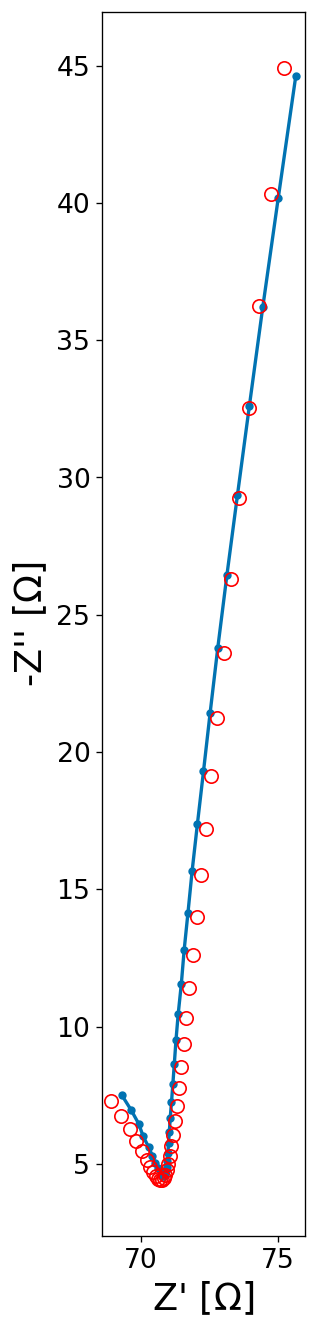

In [386]:
guesser(masked_mpt)

No handles with labels found to put in legend.


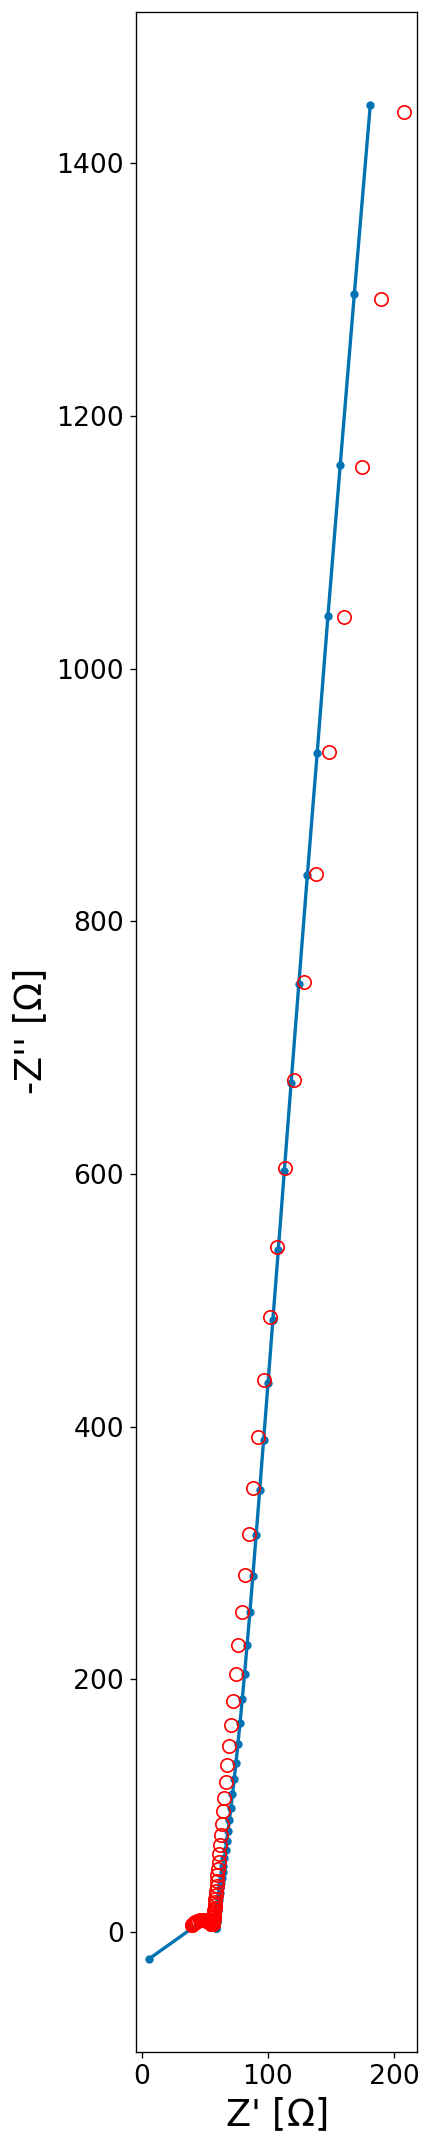

In [312]:
masked_mpt.set_new_gph_dims(50,50)
masked_mpt.mpt_plot(fitting = 'on')

In [291]:
[masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_Q[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_Q2[0]]

[42.879799474468236,
 32.63074574748704,
 1.0,
 4.877459320592803e-09,
 52559.16744391991,
 0.8559761885209822,
 2.7289078347304826e-06]

Note that there are varying amounts of iteration for convergence, you may take longer to achieve threshold

In [427]:
[ex_mpt.fit_Rs[0],ex_mpt.fit_R[0],ex_mpt.fit_n[0],ex_mpt.fit_Q[0],ex_mpt.fit_R2[0],ex_mpt.fit_n2[0],ex_mpt.fit_Q2[0]]

AttributeError: 'mpt_data' object has no attribute 'fit_Rs'

In [428]:
def masker(ex_mpt):
    skeleton = ex_mpt.df_raw.iloc[:,0:3]
    re_mid, im_mid  = mean(skeleton['re']), mean(skeleton['im'])
    a = skeleton[abs(skeleton['re']) <= re_avg * .05]
    b = skeleton[abs(skeleton['im']) <= im_avg * .05]
    c = pd.concat([a, b]).drop_duplicates()
    return [c['f'].max(), c['f'].min()]

In [429]:
masker(ex_mpt)

[1000018.6, 398.0892]

In [430]:
masked_mpt = mpt_data(path,data, mask = masker(ex_mpt))

ERROR:  960672.0740102625
ERROR:  960672.0740102625
ERROR:  960672.0740102625
ERROR:  960671.8359384455
ERROR:  960672.0721111626
ERROR:  960672.0740104419
ERROR:  960672.0740102602
ERROR:  960672.0738009786
ERROR:  960672.0740102922
ERROR:  960672.0736255131
ERROR:  20893692145999.734
ERROR:  17992108383145.45
ERROR:  26049553776116.832
ERROR:  478742719.17270863
ERROR:  478742724.0229845
ERROR:  478742758.0589595
ERROR:  478742719.1738932
ERROR:  478743010.6688132
ERROR:  478742976.039515
ERROR:  478742811.4666151
ERROR:  478742877.7961763
ERROR:  32766888.474208668
ERROR:  32766890.163703736
ERROR:  32766896.349928264
ERROR:  32766888.471848976
ERROR:  32766921.29164885
ERROR:  32766924.94267047
ERROR:  32766895.31879977
ERROR:  32766901.178421453
ERROR:  2913181.118816956
ERROR:  2913181.700823719
ERROR:  2913181.9222908416
ERROR:  2913181.1195895094
ERROR:  2913182.027954572
ERROR:  2913186.9965557978
ERROR:  2913181.803003934
ERROR:  2913182.6970261764
ERROR:  613587.3304745763
E

ERROR:  4278.094416322474
ERROR:  4278.081414235597
ERROR:  4278.096068483236
ERROR:  4278.094423007739
ERROR:  4278.1299431580865
ERROR:  4278.080027361223
ERROR:  4278.094414343028
ERROR:  4278.039578506088
ERROR:  4228.665740528715
ERROR:  4228.653629800698
ERROR:  4228.668859198095
ERROR:  4228.665745059164
ERROR:  4228.63035021893
ERROR:  4228.651657712609
ERROR:  4228.665738222451
ERROR:  4228.611846030399
ERROR:  4181.639749531953
ERROR:  4181.628545430055
ERROR:  4181.6443616192455
ERROR:  4181.639751779335
ERROR:  4181.674992358518
ERROR:  4181.625964249121
ERROR:  4181.639746935274
ERROR:  4181.586785613381
ERROR:  4137.054136435347
ERROR:  4137.043849730324
ERROR:  4137.060262835332
ERROR:  4137.0541362751055
ERROR:  4137.019052727259
ERROR:  4137.040640952491
ERROR:  4137.054133583897
ERROR:  4137.002092713273
ERROR:  4094.6996668255283
ERROR:  4094.690308841642
ERROR:  4094.707327994351
ERROR:  4094.6996641327178
ERROR:  4094.734582315431
ERROR:  4094.6864537096503
ERROR: 

ERROR:  3060.5644360642973
ERROR:  3060.5701731238405
ERROR:  3060.569471312825
ERROR:  3060.5851495475163
ERROR:  3057.5030547576534
ERROR:  3057.520425736314
ERROR:  3057.5554120571596
ERROR:  3057.5029512961582
ERROR:  3057.5081500438746
ERROR:  3057.503804740461
ERROR:  3057.5030547183987
ERROR:  3057.519049249753
ERROR:  3054.4927607125355
ERROR:  3054.510130778567
ERROR:  3054.5451130488163
ERROR:  3054.4926572976374
ERROR:  3054.4876083444615
ERROR:  3054.493557756296
ERROR:  3054.492760675181
ERROR:  3054.509064747335
ERROR:  3051.5256098328064
ERROR:  3051.5429787135417
ERROR:  3051.5779566138754
ERROR:  3051.5255064649796
ERROR:  3051.530816438619
ERROR:  3051.526452723251
ERROR:  3051.5256097972265
ERROR:  3051.542216162562
ERROR:  3048.6121877841265
ERROR:  3048.6295544939176
ERROR:  3048.664527483998
ERROR:  3048.61208446621
ERROR:  3048.606929465509
ERROR:  3048.6130754257333
ERROR:  3048.612187750252
ERROR:  3048.6290899199475
ERROR:  3045.7393141140074
ERROR:  3045.7566

ERROR:  372815.77762939746
ERROR:  373999.6759683669
ERROR:  144724.80923339885
ERROR:  144724.8217840346
ERROR:  144724.81472406993
ERROR:  144724.8100782184
ERROR:  144724.72783714184
ERROR:  144724.80580592513
ERROR:  145097.1903964825
ERROR:  129614.10021398388
ERROR:  77377.5455685906
ERROR:  77377.55074981628
ERROR:  77377.54837790747
ERROR:  77377.54493947986
ERROR:  77377.5471028871
ERROR:  77377.54460670329
ERROR:  77801.60810676852
ERROR:  56072.10893987179
ERROR:  36377.14118306556
ERROR:  36377.14279379882
ERROR:  36377.14226962107
ERROR:  36377.1412066076
ERROR:  36377.1476624922
ERROR:  36377.140946186184
ERROR:  36744.772065757854
ERROR:  17982.452379148537
ERROR:  43227.31399192221
ERROR:  15386.048464717143
ERROR:  15386.050628154306
ERROR:  15386.04988721012
ERROR:  15386.04827439809
ERROR:  15386.053207623481
ERROR:  15386.048000082925
ERROR:  15630.9457623682
ERROR:  5226.377440629667
ERROR:  10916.214256134888
ERROR:  10916.215670768988
ERROR:  10916.215024121573
E

ERROR:  318.7126898943235
ERROR:  318.7126901711491
ERROR:  318.71229427808436
ERROR:  318.71271749973806
ERROR:  318.7126311212975
ERROR:  317.1704885826955
ERROR:  317.1704352225855
ERROR:  317.17050151370046
ERROR:  317.1704885822887
ERROR:  317.17048832041223
ERROR:  317.1700938490916
ERROR:  317.1705161757847
ERROR:  317.1704299520368
ERROR:  315.6525594062827
ERROR:  315.65250671187437
ERROR:  315.65257238813064
ERROR:  315.6525594059845
ERROR:  315.6525596828702
ERROR:  315.65216552729663
ERROR:  315.6525869924473
ERROR:  315.65250091410707
ERROR:  314.1572499851476
ERROR:  314.15719790647114
ERROR:  314.1572630141567
ERROR:  314.15724998492914
ERROR:  314.15724972256606
ERROR:  314.15685693690676
ERROR:  314.1572775683332
ERROR:  314.15719162772575
ERROR:  312.6831303314233
ERROR:  312.68307882339707
ERROR:  312.68314340423063
ERROR:  312.6831303312624
ERROR:  312.6831306085293
ERROR:  312.6827380938786
ERROR:  312.68315791484036
ERROR:  312.6830721056265
ERROR:  311.2289598192

ERROR:  269.85987268258276
ERROR:  269.85987240719453
ERROR:  269.85950468609246
ERROR:  269.8599005841128
ERROR:  269.8598183840841
ERROR:  268.8273864970414
ERROR:  268.8273449146165
ERROR:  268.82740033058536
ERROR:  268.8273864970414
ERROR:  268.8273867894957
ERROR:  268.8270191330047
ERROR:  268.8274144048805
ERROR:  268.8273323003107
ERROR:  267.8036714233847
ERROR:  267.80363003800863
ERROR:  267.8036852725428
ERROR:  267.8036714233847
ERROR:  267.80367114753767
ERROR:  267.8033046891595
ERROR:  267.80369933728264
ERROR:  267.8036173279536
ERROR:  266.7886237668408
ERROR:  266.788582578004
ERROR:  266.7886376316308
ERROR:  266.7886237668408
ERROR:  266.78862405983983
ERROR:  266.78825765979366
ERROR:  266.7886516865554
ERROR:  266.7885697722455
ERROR:  265.78214183328623
ERROR:  265.7821008405126
ERROR:  265.78215571372795
ERROR:  265.78214183328623
ERROR:  265.78214155701784
ERROR:  265.7817763508029
ERROR:  265.78216975857265
ERROR:  265.7820879390689
ERROR:  264.7841228278796

ERROR:  228.93055733122586
ERROR:  228.93052777485383
ERROR:  228.93057232288356
ERROR:  228.93055733122586
ERROR:  228.9305571588044
ERROR:  228.93021652581857
ERROR:  228.9305852870984
ERROR:  228.93050737357487
ERROR:  228.22292649319087
ERROR:  228.2228971260747
ERROR:  228.22294150248214
ERROR:  228.22292649319087
ERROR:  228.22292667281985
ERROR:  228.2225862158769
ERROR:  228.22295444537076
ERROR:  228.22287661909246
ERROR:  227.52053230288607
ERROR:  227.52050312487083
ERROR:  227.52054732984237
ERROR:  227.52053230288607
ERROR:  227.52053212990324
ERROR:  227.5201925518544
ERROR:  227.5205602512136
ERROR:  227.52048251202493
ERROR:  226.82331955207067
ERROR:  226.82329056300972
ERROR:  226.82333459672472
ERROR:  226.82331955207067
ERROR:  226.82331973230671
ERROR:  226.82298032552094
ERROR:  226.82334749637027
ERROR:  226.82326984413083
ERROR:  226.13123626433074
ERROR:  226.13120746407333
ERROR:  226.13125132671493
ERROR:  226.13123626433074
ERROR:  226.13123609081745
ERROR: 

ERROR:  204.23403925000557
ERROR:  204.23396473211386
ERROR:  203.83289824835512
ERROR:  203.83287714469688
ERROR:  203.8329140739424
ERROR:  203.83289824835512
ERROR:  203.8328982494376
ERROR:  203.8325775350973
ERROR:  203.8329259241492
ERROR:  203.83285145060987
ERROR:  203.28828250818356
ERROR:  203.2882619923692
ERROR:  203.28829841658575
ERROR:  203.28828250818356
ERROR:  203.28828250706874
ERROR:  203.2879622670428
ERROR:  203.28831016865075
ERROR:  203.28823578428532
ERROR:  202.2115877207496
ERROR:  202.2115678649741
ERROR:  202.21160370758065
ERROR:  202.2115877207496
ERROR:  202.21158772415714
ERROR:  202.2112684024956
ERROR:  202.21161536036334
ERROR:  202.2115411411771
ERROR:  200.11275892113022
ERROR:  200.11274008445378
ERROR:  200.11277502063655
ERROR:  200.11275892113022
ERROR:  200.11275889704373
ERROR:  200.11244142662935
ERROR:  200.1127865218998
ERROR:  200.1127126264997
ERROR:  196.6537569776825
ERROR:  196.65373700633825
ERROR:  196.65377301457931
ERROR:  196.653

ERROR:  179.8914687340473
ERROR:  179.8914686134326
ERROR:  179.89117102406834
ERROR:  179.8914957253632
ERROR:  179.89142550772848
ERROR:  179.50394245962684
ERROR:  179.5039312478395
ERROR:  179.50395936604642
ERROR:  179.50394245962684
ERROR:  179.5039425915056
ERROR:  179.50364517133522
ERROR:  179.5039694347111
ERROR:  179.50389929831584
ERROR:  179.12012675722983
ERROR:  179.1201156434246
ERROR:  179.12014367402924
ERROR:  179.12012675722983
ERROR:  179.12012662218584
ERROR:  179.1198298894972
ERROR:  179.12015371624483
ERROR:  179.12008366073792
ERROR:  178.86795126804643
ERROR:  178.8679407505889
ERROR:  178.86796824520775
ERROR:  178.86795126804643
ERROR:  178.86795125656394
ERROR:  178.86765458452828
ERROR:  178.86797821890138
ERROR:  178.86790819998254
ERROR:  178.5198171751803
ERROR:  178.51980699366635
ERROR:  178.51983419792924
ERROR:  178.5198171751803
ERROR:  178.5198171847093
ERROR:  178.5195208641171
ERROR:  178.5198441088404
ERROR:  178.51977416453533
ERROR:  177.830

ERROR:  162.12071407588684
ERROR:  161.8272339720782
ERROR:  161.827232223723
ERROR:  161.82725196518822
ERROR:  161.8272339720782
ERROR:  161.82723405858763
ERROR:  161.82695730048388
ERROR:  161.82725997591237
ERROR:  161.82719397099856
ERROR:  161.53612522687655
ERROR:  161.5361236037098
ERROR:  161.5361432348889
ERROR:  161.53612522687655
ERROR:  161.53612513661236
ERROR:  161.535848937563
ERROR:  161.53615120972717
ERROR:  161.53608528405167
ERROR:  161.2644033487607
ERROR:  161.26440192748012
ERROR:  161.2644213781611
ERROR:  161.2644033487607
ERROR:  161.2644034253933
ERROR:  161.26412739680833
ERROR:  161.26442931303376
ERROR:  161.26436345733816
ERROR:  160.97552086228825
ERROR:  160.9755196010019
ERROR:  160.97553891164273
ERROR:  160.97552086228825
ERROR:  160.97552078263837
ERROR:  160.97524529029405
ERROR:  160.97554680510007
ERROR:  160.97548102875228
ERROR:  160.68878148973164
ERROR:  160.6887803692297
ERROR:  160.68879955611112
ERROR:  160.68878148973164
ERROR:  160.688

ERROR:  151.53472627341725
ERROR:  151.53473083455023
ERROR:  151.53474501194023
ERROR:  151.53472627341725
ERROR:  151.53472629258314
ERROR:  151.53446371826934
ERROR:  151.53475142246592
ERROR:  151.53468841604638
ERROR:  150.73699283466672
ERROR:  150.7369976470103
ERROR:  150.73701161855567
ERROR:  150.73699283466672
ERROR:  150.73699271561009
ERROR:  150.73673154915804
ERROR:  150.73701789883353
ERROR:  150.73695516936831
ERROR:  150.58571322774367
ERROR:  150.5362081869315
ERROR:  150.53621341256644
ERROR:  150.5362270058872
ERROR:  150.5362081869315
ERROR:  150.53620820951042
ERROR:  150.53594710261336
ERROR:  150.53623323882897
ERROR:  150.53617055207178
ERROR:  150.2212994181336
ERROR:  150.221304863763
ERROR:  150.22131826601682
ERROR:  150.2212994181336
ERROR:  150.2212993788614
ERROR:  150.22103880998114
ERROR:  150.2213244375658
ERROR:  150.22126185527358
ERROR:  149.76650705093797
ERROR:  149.76651228219652
ERROR:  149.76652589182294
ERROR:  149.76650705093797
ERROR:  149

ERROR:  140.68413955205506
ERROR:  140.49554555427792
ERROR:  140.4955573589231
ERROR:  140.49556517679704
ERROR:  140.49554555427792
ERROR:  140.49554561980784
ERROR:  140.49530064692033
ERROR:  140.4955694301932
ERROR:  140.49551035601365
ERROR:  140.30772214705644
ERROR:  140.30773408141613
ERROR:  140.307741785472
ERROR:  140.30772214705644
ERROR:  140.30772208264528
ERROR:  140.30747756715587
ERROR:  140.30774599722443
ERROR:  140.30768699792372
ERROR:  140.12069818420622
ERROR:  140.12071024837797
ERROR:  140.12071783853895
ERROR:  140.12069818420622
ERROR:  140.12069824978522
ERROR:  140.12045393133218
ERROR:  140.12072200858518
ERROR:  140.12066308413273
ERROR:  139.93446888871796
ERROR:  139.93448108279676
ERROR:  139.93448855898774
ERROR:  139.93446888871796
ERROR:  139.93446882432505
ERROR:  139.9342249624369
ERROR:  139.93449268726988
ERROR:  139.934433837633
ERROR:  139.7490278584932
ERROR:  139.74904018259255
ERROR:  139.74904754472226
ERROR:  139.7490278584932
ERROR:  13

ERROR:  133.22995432522913
ERROR:  133.22995741218918
ERROR:  133.22993712057337
ERROR:  133.22993717912252
ERROR:  133.22970566297647
ERROR:  133.22995987768795
ERROR:  133.22990393457118
ERROR:  133.07103900301271
ERROR:  133.0710563292848
ERROR:  133.0710593098048
ERROR:  133.07103900301271
ERROR:  133.07103894538093
ERROR:  133.07080785985494
ERROR:  133.07106173253527
ERROR:  133.07100586391687
ERROR:  132.91274931239573
ERROR:  132.91276675996988
ERROR:  132.91276963432782
ERROR:  132.91274931239573
ERROR:  132.91274937101025
ERROR:  132.91251848341727
ERROR:  132.912772014288
ERROR:  132.9127162201607
ERROR:  132.75506457044452
ERROR:  132.75508213900778
ERROR:  132.7550849074801
ERROR:  132.75506457044452
ERROR:  132.75506451275143
ERROR:  132.75483405538904
ERROR:  132.75508724466653
ERROR:  132.75503152502745
ERROR:  132.59798087189284
ERROR:  132.59799856114563
ERROR:  132.59800122399704
ERROR:  132.59798087189284
ERROR:  132.59798093057114
ERROR:  132.59775067049986
ERROR: 

ERROR:  125.30365279414507
ERROR:  125.30365015747745
ERROR:  125.30362904106443
ERROR:  125.30362908651134
ERROR:  125.30341450331994
ERROR:  125.30365022308132
ERROR:  125.30359837074673
ERROR:  125.17066419871614
ERROR:  125.17068804606456
ERROR:  125.17068532724201
ERROR:  125.17066419871614
ERROR:  125.17066415069907
ERROR:  125.1704499742241
ERROR:  125.17068534997894
ERROR:  125.17063357481541
ERROR:  125.04938639826781
ERROR:  125.049410359593
ERROR:  125.04940753994765
ERROR:  125.04938639826781
ERROR:  125.04938643785069
ERROR:  125.04917244764044
ERROR:  125.04940752265377
ERROR:  125.04935581494458
ERROR:  124.91651186281557
ERROR:  124.91653592470159
ERROR:  124.91653301735369
ERROR:  124.91651186281557
ERROR:  124.91651182073001
ERROR:  124.91629822573692
ERROR:  124.91653295626737
ERROR:  124.91648132594318
ERROR:  124.78442622473153
ERROR:  124.78445038558587
ERROR:  124.78444739204498
ERROR:  124.78442622473153
ERROR:  124.78442627057107
ERROR:  124.78421290100945
ERRO

ERROR:  114.48077284129181
ERROR:  114.48080608045443
ERROR:  114.48079515875295
ERROR:  114.48077284129181
ERROR:  114.48077287354621
ERROR:  114.48058694236562
ERROR:  114.48079097739856
ERROR:  114.48074639384889
ERROR:  114.3830136401037
ERROR:  114.38304696186765
ERROR:  114.38303596822594
ERROR:  114.3830136401037
ERROR:  114.38301360589203
ERROR:  114.38282804122797
ERROR:  114.38303174200274
ERROR:  114.38298723669365
ERROR:  114.28574225544764
ERROR:  114.28577565806539
ERROR:  114.28576459405322
ERROR:  114.28574225544764
ERROR:  114.28574229248659
ERROR:  114.28555695651238
ERROR:  114.28576032311005
ERROR:  114.28571589605177
ERROR:  114.19760847250875
ERROR:  114.19764196483041
ERROR:  114.19763082174714
ERROR:  114.19760847250875
ERROR:  114.19760844264168
ERROR:  114.1974234360531
ERROR:  114.1976265102239
ERROR:  114.19758215162499
ERROR:  114.10043328470093
ERROR:  114.10046685979867
ERROR:  114.10045564454326
ERROR:  114.10043328470093
ERROR:  114.10043331708751
ERROR

ERROR:  110.87050277935852
ERROR:  110.87032842103905
ERROR:  110.87051952695603
ERROR:  110.8704779909055
ERROR:  110.79095525450933
ERROR:  110.79099183588629
ERROR:  110.79097799443102
ERROR:  110.79095525450933
ERROR:  110.79095522405427
ERROR:  110.79078119509127
ERROR:  110.79097200815637
ERROR:  110.79093054158905
ERROR:  110.70369115171201
ERROR:  110.70372780824692
ERROR:  110.70371390132206
ERROR:  110.70369115171201
ERROR:  110.70369118511263
ERROR:  110.70351739134938
ERROR:  110.7037078695872
ERROR:  110.7036664825261
ERROR:  110.61695257751816
ERROR:  110.61698930851998
ERROR:  110.61697533686886
ERROR:  110.61695257751816
ERROR:  110.61695254164184
ERROR:  110.61677911619682
ERROR:  110.6169692595675
ERROR:  110.61692795206248
ERROR:  110.53703417213335
ERROR:  110.53707098561036
ERROR:  110.5370569414082
ERROR:  110.53703417213335
ERROR:  110.53703420342669
ERROR:  110.53686097772697
ERROR:  110.53705082221211
ERROR:  110.537009585707
ERROR:  110.45124846532816
ERROR:  

ERROR:  106.69682376458374
ERROR:  106.69682378290727
ERROR:  106.69666453980278
ERROR:  106.69683869639617
ERROR:  106.69680121691701
ERROR:  106.62359150632813
ERROR:  106.62363203539465
ERROR:  106.62361474462513
ERROR:  106.62359150632813
ERROR:  106.62359148807843
ERROR:  106.6234325666097
ERROR:  106.62360640222565
ERROR:  106.62356900018636
ERROR:  106.55055888797787
ERROR:  106.55059948571947
ERROR:  106.55058213492225
ERROR:  106.55055888797787
ERROR:  106.55055890636324
ERROR:  106.55040023329926
ERROR:  106.5505737479357
ERROR:  106.55053642335395
ERROR:  106.47772487059355
ERROR:  106.47776553664977
ERROR:  106.47774812613278
ERROR:  106.47772487059355
ERROR:  106.47772485228361
ERROR:  106.47756650092603
ERROR:  106.47773969458419
ERROR:  106.47770244748254
ERROR:  106.40508809613242
ERROR:  106.40512883016537
ERROR:  106.40511136021786
ERROR:  106.40508809613242
ERROR:  106.40508811457873
ERROR:  106.40493001145651
ERROR:  106.40510288412885
ERROR:  106.40506571452569
ERR

ERROR:  103.98100730791256
ERROR:  103.98116893548462
ERROR:  103.98113449387844
ERROR:  103.91513371668178
ERROR:  103.9151767464429
ERROR:  103.91515726722527
ERROR:  103.91513371668178
ERROR:  103.915133736056
ERROR:  103.91498588348317
ERROR:  103.9151471893318
ERROR:  103.9151128261395
ERROR:  103.8492842532878
ERROR:  103.84932734335759
ERROR:  103.84930781131222
ERROR:  103.8492842532878
ERROR:  103.84928423401061
ERROR:  103.84913670475422
ERROR:  103.84929768885077
ERROR:  103.8492634040968
ERROR:  103.78360629755338
ERROR:  103.78364944775964
ERROR:  103.78362986303596
ERROR:  103.78360629755338
ERROR:  103.78360631697124
ERROR:  103.78345903368513
ERROR:  103.78361969600027
ERROR:  103.78358548971413
ERROR:  103.71809977642121
ERROR:  103.718142986589
ERROR:  103.71812334933706
ERROR:  103.71809977642121
ERROR:  103.71809975710119
ERROR:  103.71795279721505
ERROR:  103.71811313772169
ERROR:  103.71807900992573
ERROR:  103.65276385834404
ERROR:  103.65280712830528
ERROR:  103

ERROR:  101.52904160990715
ERROR:  101.4693692527995
ERROR:  101.469414510042
ERROR:  101.46939307801688
ERROR:  101.4693692527995
ERROR:  101.46936923282212
ERROR:  101.46923252507635
ERROR:  101.46938125731431
ERROR:  101.46934997349805
ERROR:  101.40983034805389
ERROR:  101.40987565913827
ERROR:  101.40985417986371
ERROR:  101.40983034805389
ERROR:  101.40983036817642
ERROR:  101.40969390527191
ERROR:  101.40984231434116
ERROR:  101.40981111003964
ERROR:  101.35044365063385
ERROR:  101.35048901540253
ERROR:  101.35046748901416
ERROR:  101.35044365063385
ERROR:  101.35044363062548
ERROR:  101.35030749280796
ERROR:  101.35045557867039
ERROR:  101.3504244539081
ERROR:  101.2912085413792
ERROR:  101.29125395967323
ERROR:  101.29123238630804
ERROR:  101.2912085413792
ERROR:  101.29120856153274
ERROR:  101.29107266852195
ERROR:  101.29122043113497
ERROR:  101.2911893859418
ERROR:  101.23212468131082
ERROR:  101.23217015297058
ERROR:  101.23214853276619
ERROR:  101.23212468131082
ERROR:  1

ERROR:  99.20240928561186
ERROR:  99.20245657558822
ERROR:  99.20243335777006
ERROR:  99.20240928561186
ERROR:  99.20240926509717
ERROR:  99.20228396854678
ERROR:  99.2024197392117
ERROR:  99.20239165777784
ERROR:  99.14863976832385
ERROR:  99.14868710602676
ERROR:  99.14866384622604
ERROR:  99.14863976832385
ERROR:  99.14863978898757
ERROR:  99.1485147369213
ERROR:  99.14865018258507
ERROR:  99.14862218178294
ERROR:  99.09500684496544
ERROR:  99.09505423024618
ERROR:  99.09503092859141
ERROR:  99.09500684496544
ERROR:  99.09500682442817
ERROR:  99.09488209924395
ERROR:  99.09501721985966
ERROR:  99.09498929971907
ERROR:  99.04150998548813
ERROR:  99.04155741820198
ERROR:  99.04153407481695
ERROR:  99.04150998548813
ERROR:  99.04151000617473
ERROR:  99.04138552547097
ERROR:  99.04152032098943
ERROR:  99.04149248153766
ERROR:  98.9881490401713
ERROR:  98.98819652017097
ERROR:  98.98817313518319
ERROR:  98.9881490401713
ERROR:  98.98814901961165
ERROR:  98.98802486588053
ERROR:  98.98815

ERROR:  97.0096019132161
ERROR:  97.00957732336961
ERROR:  96.96140702995831
ERROR:  96.96145628532146
ERROR:  96.96143133607636
ERROR:  96.96140702995831
ERROR:  96.96140700901842
ERROR:  96.96129430268874
ERROR:  96.96141572791005
ERROR:  96.9613912198363
ERROR:  96.9133443281243
ERROR:  96.91339362505734
ERROR:  96.91336863912596
ERROR:  96.9133443281243
ERROR:  96.91334434921751
ERROR:  96.91323188747606
ERROR:  96.91335298560683
ERROR:  96.91332855933244
ERROR:  96.86540478813723
ERROR:  96.86545412650597
ERROR:  96.86542910400392
ERROR:  96.86540478813723
ERROR:  96.86540476718113
ERROR:  96.86529263413212
ERROR:  96.86541340512704
ERROR:  96.86538906067757
ERROR:  96.8175882590245
ERROR:  96.81763763869775
ERROR:  96.8176125797375
ERROR:  96.8175882590245
ERROR:  96.81758828013395
ERROR:  96.81747639168012
ERROR:  96.81759683549986
ERROR:  96.81757257289772
ERROR:  96.76989420996833
ERROR:  96.76994363081364
ERROR:  96.76991853550965
ERROR:  96.76989420996833
ERROR:  96.76989418

ERROR:  93.56448004630438
ERROR:  93.56445541234143
ERROR:  93.56445539092655
ERROR:  93.56436508357294
ERROR:  93.56446088953584
ERROR:  93.56444282567497
ERROR:  93.52531726734895
ERROR:  93.52536941992099
ERROR:  93.52534190485615
ERROR:  93.52531726734895
ERROR:  93.52531728892302
ERROR:  93.52522722589225
ERROR:  93.52532270253428
ERROR:  93.5253047219494
ERROR:  93.48628588404824
ERROR:  93.48633806857426
ERROR:  93.48631052508377
ERROR:  93.48628588404824
ERROR:  93.48628586262434
ERROR:  93.48619612989208
ERROR:  93.48629127720699
ERROR:  93.48627337991184
ERROR:  93.44736113239348
ERROR:  93.44741334876551
ERROR:  93.44738577694189
ERROR:  93.44736113239348
ERROR:  93.44736115397656
ERROR:  93.4472716655252
ERROR:  93.44736648351687
ERROR:  93.44734866951583
ERROR:  93.40854261271137
ERROR:  93.40859486081666
ERROR:  93.40856726075722
ERROR:  93.40854261271137
ERROR:  93.40854259127914
ERROR:  93.40845343312066
ERROR:  93.40854792178084
ERROR:  93.40853019108975
ERROR:  93.369

ERROR:  91.69116282033858
ERROR:  91.1668059570285
ERROR:  91.16686008586386
ERROR:  91.16683080862921
ERROR:  91.1668059570285
ERROR:  91.1668059552726
ERROR:  91.16673481713559
ERROR:  91.16680859657882
ERROR:  91.16679612221218
ERROR:  91.06440282343847
ERROR:  91.06445701485
ERROR:  91.06442768024401
ERROR:  91.06440282343847
ERROR:  91.06440283286139
ERROR:  91.06433258771206
ERROR:  91.06440532815398
ERROR:  91.06439311807509
ERROR:  90.94578588105256
ERROR:  91.02362256439852
ERROR:  91.02367678464982
ERROR:  91.02364742437578
ERROR:  91.02362256439852
ERROR:  91.0236225493985
ERROR:  91.02355269842091
ERROR:  91.02362501380864
ERROR:  91.02361291196996
ERROR:  90.99108846146015
ERROR:  90.9911427070935
ERROR:  90.99111332413386
ERROR:  90.99108846146015
ERROR:  90.99108847733858
ERROR:  90.99101888750953
ERROR:  90.99109086718457
ERROR:  90.9910788508369
ERROR:  90.95866088606678
ERROR:  90.95871515546759
ERROR:  90.95868575117535
ERROR:  90.95866088606678
ERROR:  90.9586608694

ERROR:  89.84709818077029
ERROR:  89.84708931836327
ERROR:  89.81806034053709
ERROR:  89.81811546454229
ERROR:  89.81808528794059
ERROR:  89.81806034053709
ERROR:  89.81806032445247
ERROR:  89.81800181421255
ERROR:  89.81806108732798
ERROR:  89.81805231003592
ERROR:  89.78917671374514
ERROR:  89.78923185858942
ERROR:  89.78920166315424
ERROR:  89.78917671374514
ERROR:  89.78917673101645
ERROR:  89.78911847713645
ERROR:  89.78917741684677
ERROR:  89.7891687246454
ERROR:  89.76044109164201
ERROR:  89.7604962568887
ERROR:  89.76046604301993
ERROR:  89.76044109164201
ERROR:  89.76044107331629
ERROR:  89.76038314460227
ERROR:  89.760441751065
ERROR:  89.76043314392072
ERROR:  89.7344647285853
ERROR:  89.73451991734785
ERROR:  89.73448968208506
ERROR:  89.7344647285853
ERROR:  89.73446474351073
ERROR:  89.73440703481371
ERROR:  89.73446534982133
ERROR:  89.73445681705353
ERROR:  89.70555455748942
ERROR:  89.70560976624277
ERROR:  89.70557951283429
ERROR:  89.70555455748942
ERROR:  89.7055545

ERROR:  88.75745417723063
ERROR:  88.75742328019618
ERROR:  88.75739826131671
ERROR:  88.75739824351639
ERROR:  88.75735087217076
ERROR:  88.75739732399119
ERROR:  88.75739182101934
ERROR:  88.73403671056596
ERROR:  88.7340926468904
ERROR:  88.73406173118119
ERROR:  88.73403671056596
ERROR:  88.73403672593378
ERROR:  88.73398957561568
ERROR:  88.73403573470954
ERROR:  88.73403030653115
ERROR:  88.70883937641818
ERROR:  88.70889533007356
ERROR:  88.70886439849644
ERROR:  88.70883937641818
ERROR:  88.70883936009801
ERROR:  88.70879252413403
ERROR:  88.70883835770876
ERROR:  88.70883301270686
ERROR:  88.68378901728451
ERROR:  88.68384498838951
ERROR:  88.68381404088439
ERROR:  88.68378901728451
ERROR:  88.68378903481079
ERROR:  88.68374244746445
ERROR:  88.68378795573746
ERROR:  88.68378269386551
ERROR:  88.65888068028312
ERROR:  88.65893666833063
ERROR:  88.65890570535745
ERROR:  88.65888068028312
ERROR:  88.65888066168996
ERROR:  88.65883439270758
ERROR:  88.65887957593077
ERROR:  88.65

ERROR:  87.3611827804327
ERROR:  87.36115220015286
ERROR:  87.36117928661291
ERROR:  87.36117873219226
ERROR:  87.31433996556578
ERROR:  87.31439697074464
ERROR:  87.31436507094553
ERROR:  87.31433996556578
ERROR:  87.31433995306824
ERROR:  87.31431001666533
ERROR:  87.31433637954488
ERROR:  87.31433600992884
ERROR:  87.27928186232604
ERROR:  87.29791813653658
ERROR:  87.29797515781522
ERROR:  87.29794324314231
ERROR:  87.29791813653658
ERROR:  87.29791814454819
ERROR:  87.2978883983195
ERROR:  87.29791451850384
ERROR:  87.29791421087313
ERROR:  87.2781405888493
ERROR:  87.27819762423698
ERROR:  87.27816569639691
ERROR:  87.2781405888493
ERROR:  87.27814058047557
ERROR:  87.27811111366942
ERROR:  87.278136930856
ERROR:  87.27813670060608
ERROR:  87.25845152369955
ERROR:  87.25850857319125
ERROR:  87.25847663219683
ERROR:  87.25845152369955
ERROR:  87.25845153250243
ERROR:  87.25842231122782
ERROR:  87.25844782579485
ERROR:  87.25844767282905
ERROR:  87.23884880024079
ERROR:  87.2389058

ERROR:  86.61217989219722
ERROR:  86.6121547575406
ERROR:  86.61215476638887
ERROR:  86.61213456524044
ERROR:  86.61214969108667
ERROR:  86.61215218887101
ERROR:  86.59547139845303
ERROR:  86.59552891259001
ERROR:  86.59549653365985
ERROR:  86.59547139845303
ERROR:  86.59547138962338
ERROR:  86.59545145038204
ERROR:  86.59546629500811
ERROR:  86.59546886447323
ERROR:  86.57885441784134
ERROR:  86.57891194333806
ERROR:  86.57887955358922
ERROR:  86.57885441784134
ERROR:  86.57885442670724
ERROR:  86.57883471363562
ERROR:  86.57884927746454
ERROR:  86.57885191849809
ERROR:  86.56230365225656
ERROR:  86.56236118905409
ERROR:  86.56232878853697
ERROR:  86.56230365225656
ERROR:  86.56230364340925
ERROR:  86.56228419154914
ERROR:  86.56229847500775
ERROR:  86.56230118749652
ERROR:  86.54581864645948
ERROR:  86.54587619449906
ERROR:  86.54584378326328
ERROR:  86.54581864645948
ERROR:  86.54581865534281
ERROR:  86.54579942888569
ERROR:  86.54581343239859
ERROR:  86.54581621622975
ERROR:  86.52

ERROR:  85.9802944539186
ERROR:  85.98035237896102
ERROR:  85.98031960418683
ERROR:  85.9802944539186
ERROR:  85.980294444762
ERROR:  85.98028396426332
ERROR:  85.98028792207728
ERROR:  85.9802932622661
ERROR:  85.96615921545748
ERROR:  85.96621714966888
ERROR:  85.96618436593451
ERROR:  85.96615921545748
ERROR:  85.96615922465139
ERROR:  85.96614895417505
ERROR:  85.96615264925077
ERROR:  85.9661580561874
ERROR:  85.95208180262841
ERROR:  85.95213974595295
ERROR:  85.9521069533054
ERROR:  85.95208180262841
ERROR:  85.95208179345659
ERROR:  85.95207176930916
ERROR:  85.95207520212766
ERROR:  85.95208067568126
ERROR:  85.93806213638518
ERROR:  85.93812008877387
ERROR:  85.93808728725534
ERROR:  85.93806213638518
ERROR:  85.9380621455945
ERROR:  85.93805233061691
ERROR:  85.93805550165659
ERROR:  85.93806104170154
ERROR:  85.92409966277603
ERROR:  85.92415762417428
ERROR:  85.92412481383045
ERROR:  85.92409966277603
ERROR:  85.92409965358924
ERROR:  85.9240900841498
ERROR:  85.9240929938

ERROR:  85.02523486723678
ERROR:  85.02520972411422
ERROR:  85.02520973383704
ERROR:  85.02521596391371
ERROR:  85.02520069958439
ERROR:  85.02521090086091
ERROR:  85.0150045180258
ERROR:  85.01506301846266
ERROR:  85.01502966076347
ERROR:  85.0150045180258
ERROR:  85.01500450833069
ERROR:  85.01501095209717
ERROR:  85.01499546492578
ERROR:  85.01500572222805
ERROR:  85.00484106129198
ERROR:  85.00489956698505
ERROR:  85.00486620363785
ERROR:  85.00484106129198
ERROR:  85.00484107102676
ERROR:  85.00484768919256
ERROR:  85.00483197969564
ERROR:  85.0048422928852
ERROR:  84.99471927544263
ERROR:  84.99477778634504
ERROR:  84.99474441738897
ERROR:  84.99471927544263
ERROR:  84.9947192657355
ERROR:  84.99472609673037
ERROR:  84.9947101654275
ERROR:  84.99472053436415
ERROR:  84.98463902650366
ERROR:  84.98469754257059
ERROR:  84.9846641680439
ERROR:  84.98463902650366
ERROR:  84.9846390362504
ERROR:  84.9846460407339
ERROR:  84.98462988814295
ERROR:  84.98464031268901
ERROR:  84.974599919

ERROR:  84.63914653580886
ERROR:  84.63914652589122
ERROR:  84.63916037914284
ERROR:  84.6391364018685
ERROR:  84.63914878620697
ERROR:  84.63050863120715
ERROR:  84.63056731016331
ERROR:  84.63053375218374
ERROR:  84.63050863120715
ERROR:  84.63050864116562
ERROR:  84.63052265079385
ERROR:  84.63049847178623
ERROR:  84.63051090647033
ERROR:  84.62190525862908
ERROR:  84.62196394100998
ERROR:  84.62193037893216
ERROR:  84.62190525862908
ERROR:  84.62190524870101
ERROR:  84.621919454036
ERROR:  84.62189507380353
ERROR:  84.62190755869447
ERROR:  84.61333627820568
ERROR:  84.61339496397049
ERROR:  84.61336139782799
ERROR:  84.61333627820568
ERROR:  84.61333628817445
ERROR:  84.6133506490023
ERROR:  84.61332606804837
ERROR:  84.61333860301195
ERROR:  84.60480165761084
ERROR:  84.60486034671358
ERROR:  84.60482677654669
ERROR:  84.60480165761084
ERROR:  84.60480164767257
ERROR:  84.60481620336323
ERROR:  84.60479142219414
ERROR:  84.60480400709531
ERROR:  84.59630119863027
ERROR:  84.59635

ERROR:  84.31911748637864
ERROR:  84.31909239652843
ERROR:  84.31909238641441
ERROR:  84.31911295682772
ERROR:  84.31908130058005
ERROR:  84.31909559371712
ERROR:  84.31171939611725
ERROR:  84.31177817876724
ERROR:  84.311744485041
ERROR:  84.31171939611725
ERROR:  84.3117194062728
ERROR:  84.31174011573529
ERROR:  84.31170827759826
ERROR:  84.31172261574255
ERROR:  84.304375030922
ERROR:  84.30443381530479
ERROR:  84.30440011891288
ERROR:  84.304375030922
ERROR:  84.30437502079889
ERROR:  84.30439590944826
ERROR:  84.30436388989848
ERROR:  84.3043782729242
ERROR:  84.29705917348589
ERROR:  84.29711795955782
ERROR:  84.29708426053747
ERROR:  84.29705917348589
ERROR:  84.2970591836508
ERROR:  84.29708021050982
ERROR:  84.29704801003001
ERROR:  84.29706243780664
ERROR:  84.28977167794366
ERROR:  84.28983046566519
ERROR:  84.28979676404958
ERROR:  84.28977167794366
ERROR:  84.28977166781142
ERROR:  84.28979287305674
ERROR:  84.28976049212426
ERROR:  84.28977496452436
ERROR:  84.2825124403

ERROR:  84.03262877983056
ERROR:  84.03260373420589
ERROR:  84.03260372391135
ERROR:  84.03263064046266
ERROR:  84.0325917493301
ERROR:  84.03260782426585
ERROR:  84.02632435915139
ERROR:  84.02638317966313
ERROR:  84.02634940359387
ERROR:  84.02632435915139
ERROR:  84.02632436948876
ERROR:  84.026351408109
ERROR:  84.02631235454527
ERROR:  84.02632846926983
ERROR:  84.02006854222887
ERROR:  84.0201273627856
ERROR:  84.02009358548247
ERROR:  84.02006854222887
ERROR:  84.02006853192626
ERROR:  84.02009573350634
ERROR:  84.02005651795795
ERROR:  84.02007267235068
ERROR:  84.01383606233814
ERROR:  84.01389488290575
ERROR:  84.01386110439807
ERROR:  84.01383606233814
ERROR:  84.0138360726834
ERROR:  84.01386339555887
ERROR:  84.01382401846675
ERROR:  84.01384021240985
ERROR:  84.00762687768866
ERROR:  84.00768569822381
ERROR:  84.00765191854839
ERROR:  84.00762687768866
ERROR:  84.00762686737806
ERROR:  84.00765435247578
ERROR:  84.00761481428206
ERROR:  84.00763104765697
ERROR:  84.001440

ERROR:  83.7987162406407
ERROR:  83.798733817275
ERROR:  83.79330982061649
ERROR:  83.79336861320856
ERROR:  83.79333481305352
ERROR:  83.79330982061649
ERROR:  83.79330983110512
ERROR:  83.79334227632991
ERROR:  83.79329707812678
ERROR:  83.79331469002383
ERROR:  83.7879103012131
ERROR:  83.78796909233971
ERROR:  83.78793529223518
ERROR:  83.7879103012131
ERROR:  83.78791029076103
ERROR:  83.78794288481636
ERROR:  83.78789754151188
ERROR:  83.78791518856283
ERROR:  83.78253026995743
ERROR:  83.78258905958238
ERROR:  83.78255525955977
ERROR:  83.78253026995743
ERROR:  83.78253028045309
ERROR:  83.78256298110637
ERROR:  83.78251749310635
ERROR:  83.78253517520122
ERROR:  83.77716965616997
ERROR:  83.77722844425492
ERROR:  83.77719464434661
ERROR:  83.77716965616997
ERROR:  83.77716964571104
ERROR:  83.77720249452369
ERROR:  83.77715686222426
ERROR:  83.77717457925914
ERROR:  83.77182830673216
ERROR:  83.77188709324177
ERROR:  83.77185329347796
ERROR:  83.77182830673216
ERROR:  83.771828

ERROR:  83.59639523069
ERROR:  83.59641413700479
ERROR:  83.59170877063418
ERROR:  83.5917674766558
ERROR:  83.59173370235452
ERROR:  83.59170877063418
ERROR:  83.59170878125492
ERROR:  83.59174608349925
ERROR:  83.59169538339219
ERROR:  83.591714320906
ERROR:  83.58702542955042
ERROR:  83.58708413269024
ERROR:  83.58705035964789
ERROR:  83.58702542955042
ERROR:  83.58702541896794
ERROR:  83.58706285729602
ERROR:  83.58701202729401
ERROR:  83.5870309959114
ERROR:  83.58235837294704
ERROR:  83.58241707317028
ERROR:  83.58238330141585
ERROR:  83.58235837294704
ERROR:  83.582358383574
ERROR:  83.58239591526714
ERROR:  83.58234495572691
ERROR:  83.5823639553521
ERROR:  83.57770767071311
ERROR:  83.5777663679864
ERROR:  83.57773259754862
ERROR:  83.57770767071311
ERROR:  83.57770766012447
ERROR:  83.57774532730119
ERROR:  83.57769423857754
ERROR:  83.57771326911914
ERROR:  83.57307321497369
ERROR:  83.57313190926328
ERROR:  83.5730981401711
ERROR:  83.57307321497369
ERROR:  83.5730732256065

ERROR:  83.4205733387665
ERROR:  83.4205934213735
ERROR:  83.41649457369938
ERROR:  83.41655313848536
ERROR:  83.4165194367223
ERROR:  83.41649457369938
ERROR:  83.41649458443526
ERROR:  83.41653625096987
ERROR:  83.41648062443667
ERROR:  83.41650073464363
ERROR:  83.41241587397191
ERROR:  83.41247443456095
ERROR:  83.4124407351819
ERROR:  83.41241587397191
ERROR:  83.41241586327581
ERROR:  83.41245765451946
ERROR:  83.4124019116335
ERROR:  83.4124220493534
ERROR:  83.40835103283251
ERROR:  83.40840958919573
ERROR:  83.40837589222475
ERROR:  83.40835103283251
ERROR:  83.40835104357367
ERROR:  83.4083929163851
ERROR:  83.40833705746053
ERROR:  83.40835722261205
ERROR:  83.40430015999834
ERROR:  83.40435871210397
ERROR:  83.40432501756825
ERROR:  83.40430015999834
ERROR:  83.40430014929674
ERROR:  83.40434214628169
ERROR:  83.40428617163803
ERROR:  83.40430636413711
ERROR:  83.40026302440225
ERROR:  83.40032157221901
ERROR:  83.40028788014557
ERROR:  83.40026302440225
ERROR:  83.40026303

ERROR:  83.17187918958763
ERROR:  83.16857829274653
ERROR:  83.16863652054445
ERROR:  83.16860302553775
ERROR:  83.16857829274653
ERROR:  83.16857828348745
ERROR:  83.16862639029787
ERROR:  83.16856355254524
ERROR:  83.16858534982593
ERROR:  83.16545795975229
ERROR:  83.16551618323837
ERROR:  83.1654826907441
ERROR:  83.16545795975229
ERROR:  83.16545796724088
ERROR:  83.16550613550756
ERROR:  83.16544321021836
ERROR:  83.16546502773028
ERROR:  83.16213315562968
ERROR:  83.16219137195229
ERROR:  83.1621578843545
ERROR:  83.16213315562968
ERROR:  83.16213314749041
ERROR:  83.16218142166464
ERROR:  83.16211839532436
ERROR:  83.1621402361872
ERROR:  83.15884442165702
ERROR:  83.15890263089959
ERROR:  83.15886914814669
ERROR:  83.15884442165702
ERROR:  83.15884443055741
ERROR:  83.15889277773894
ERROR:  83.15882965061721
ERROR:  83.1588515147616
ERROR:  83.1557244022339
ERROR:  83.15578260658374
ERROR:  83.15574912683942
ERROR:  83.1557244022339
ERROR:  83.15572439456895
ERROR:  83.1557728

ERROR:  83.04936712836667
ERROR:  83.04930069005997
ERROR:  83.04932331410308
ERROR:  83.04641736783077
ERROR:  83.04647532849705
ERROR:  83.04644201407444
ERROR:  83.04641736783077
ERROR:  83.0464173595833
ERROR:  83.04646876872314
ERROR:  83.04640224024061
ERROR:  83.04642488483688
ERROR:  83.04354331436451
ERROR:  83.04360126730265
ERROR:  83.04356795829565
ERROR:  83.04354331436451
ERROR:  83.04354332315552
ERROR:  83.04359479592624
ERROR:  83.04352817749935
ERROR:  83.04355084259197
ERROR:  83.04069208055762
ERROR:  83.04075002562568
ERROR:  83.04071672216305
ERROR:  83.04069208055762
ERROR:  83.04069207124867
ERROR:  83.04074364257964
ERROR:  83.04067693444968
ERROR:  83.04069961997655
ERROR:  83.03794502483296
ERROR:  83.03800296464244
ERROR:  83.03796966450794
ERROR:  83.03794502483296
ERROR:  83.03794503244475
ERROR:  83.0379966574705
ERROR:  83.0379298706295
ERROR:  83.03795257407283
ERROR:  83.03505897627825
ERROR:  83.03511690781406
ERROR:  83.03508361353869
ERROR:  83.0350

ERROR:  82.91236530746987
ERROR:  82.9123322641053
ERROR:  82.91230773418029
ERROR:  82.91230772640395
ERROR:  82.91236289561992
ERROR:  82.91229218469307
ERROR:  82.91231577368829
ERROR:  82.90998284289847
ERROR:  82.91004040904375
ERROR:  82.91000737064967
ERROR:  82.90998284289847
ERROR:  82.90998284949102
ERROR:  82.91003806797286
ERROR:  82.90996728647215
ERROR:  82.90999089123703
ERROR:  82.90754499415964
ERROR:  82.9076025511265
ERROR:  82.90756951938297
ERROR:  82.90754499415964
ERROR:  82.90754498717806
ERROR:  82.90760029016576
ERROR:  82.90752943000265
ERROR:  82.90755305234197
ERROR:  82.90512637701102
ERROR:  82.90518392489402
ERROR:  82.9051508997298
ERROR:  82.90512637701102
ERROR:  82.90512638444336
ERROR:  82.90518174377766
ERROR:  82.90511080514716
ERROR:  82.90513444501158
ERROR:  82.90272547531481
ERROR:  82.902783014056
ERROR:  82.90274999552668
ERROR:  82.90272547531481
ERROR:  82.90272546744741
ERROR:  82.90278091266674
ERROR:  82.90270989576976
ERROR:  82.902733

ERROR:  82.74854893973874
ERROR:  82.7466717582477
ERROR:  82.74672862312647
ERROR:  82.74669609516376
ERROR:  82.7466717582477
ERROR:  82.74667175049632
ERROR:  82.74673184804377
ERROR:  82.74665569192226
ERROR:  82.74668048054686
ERROR:  82.74482163209304
ERROR:  82.74487848653156
ERROR:  82.74484596635305
ERROR:  82.74482163209304
ERROR:  82.7448216404018
ERROR:  82.7448817812206
ERROR:  82.74480555982308
ERROR:  82.74483036259765
ERROR:  82.74354123795825
ERROR:  82.74359809121529
ERROR:  82.7435655713027
ERROR:  82.74354123795825
ERROR:  82.74354123881302
ERROR:  82.74360141271752
ERROR:  82.74352516313601
ERROR:  82.74354997200784
ERROR:  82.74185325741475
ERROR:  82.74191010213472
ERROR:  82.74187758847718
ERROR:  82.74185325741475
ERROR:  82.74185325673187
ERROR:  82.74191348358228
ERROR:  82.74183717745474
ERROR:  82.7418619985729
ERROR:  82.73852264220112
ERROR:  82.73857947091162
ERROR:  82.73854696890102
ERROR:  82.73852264220112
ERROR:  82.73852264399079
ERROR:  82.7385829

ERROR:  82.63709329491785
ERROR:  82.63706912786488
ERROR:  82.63706912197287
ERROR:  82.63713273584317
ERROR:  82.6370527219523
ERROR:  82.63707833602777
ERROR:  82.63558221206713
ERROR:  82.63563840412398
ERROR:  82.63560637636756
ERROR:  82.63558221206713
ERROR:  82.63558221825879
ERROR:  82.63564587072595
ERROR:  82.63556580146118
ERROR:  82.63559142721913
ERROR:  82.63410665178867
ERROR:  82.63416283267507
ERROR:  82.63413081335023
ERROR:  82.63410665178867
ERROR:  82.63410664531304
ERROR:  82.63417036101949
ERROR:  82.63409023650802
ERROR:  82.63411587391444
ERROR:  82.63264138442733
ERROR:  82.63269755410965
ERROR:  82.63266554324916
ERROR:  82.63264138442733
ERROR:  82.63264139123314
ERROR:  82.63270514411244
ERROR:  82.63262496448428
ERROR:  82.63265061350964
ERROR:  82.63121063280828
ERROR:  82.63126679304052
ERROR:  82.63123478919339
ERROR:  82.63121063280828
ERROR:  82.63121062695822
ERROR:  82.63127443824312
ERROR:  82.63119420864548
ERROR:  82.63121986819895
ERROR:  82.62

ERROR:  82.58202248201226
ERROR:  82.58199077356647
ERROR:  82.581966713419
ERROR:  82.58196670708688
ERROR:  82.58203222508149
ERROR:  82.58195013545304
ERROR:  82.58197618387943
ERROR:  82.58068603268676
ERROR:  82.58074178959289
ERROR:  82.58071009003984
ERROR:  82.58068603268676
ERROR:  82.5806860395354
ERROR:  82.58075159148964
ERROR:  82.58066945057203
ERROR:  82.58069550963701
ERROR:  82.57942549162668
ERROR:  82.57948123884007
ERROR:  82.57944954652818
ERROR:  82.57942549162668
ERROR:  82.57942548568226
ERROR:  82.5794910927354
ERROR:  82.57940890579518
ERROR:  82.57943497439952
ERROR:  82.57814614358408
ERROR:  82.5782018792178
ERROR:  82.57817019570443
ERROR:  82.57814614358408
ERROR:  82.57814614991844
ERROR:  82.57821179127173
ERROR:  82.57812955366337
ERROR:  82.57815563276867
ERROR:  82.57688046580154
ERROR:  82.57693618987622
ERROR:  82.57690451515113
ERROR:  82.57688046580154
ERROR:  82.57688045908466
ERROR:  82.57694615996772
ERROR:  82.57686387180576
ERROR:  82.576889

ERROR:  82.52058859073794
ERROR:  82.52065636702133
ERROR:  82.52057182423809
ERROR:  82.52059837592272
ERROR:  82.51953987854397
ERROR:  82.51959505605657
ERROR:  82.5195637958061
ERROR:  82.51953987854397
ERROR:  82.51953988238455
ERROR:  82.51960769160955
ERROR:  82.5195231048834
ERROR:  82.51954966547613
ERROR:  82.51849516300926
ERROR:  82.51855032910385
ERROR:  82.51851907756449
ERROR:  82.51849516300926
ERROR:  82.51849515917056
ERROR:  82.51856301660546
ERROR:  82.5184783860349
ERROR:  82.51850495550802
ERROR:  82.51745443244819
ERROR:  82.51750958712164
ERROR:  82.51747834429756
ERROR:  82.51745443244819
ERROR:  82.51745443629628
ERROR:  82.51752232649035
ERROR:  82.51743765216638
ERROR:  82.51746423050287
ERROR:  82.51641768489266
ERROR:  82.51647282813616
ERROR:  82.51644159403504
ERROR:  82.51641768489266
ERROR:  82.51641768104602
ERROR:  82.51648561929764
ERROR:  82.51640090132187
ERROR:  82.51642748849058
ERROR:  82.51538491846341
ERROR:  82.51544005027363
ERROR:  82.5154

ERROR:  82.48078310506128
ERROR:  82.4807592962114
ERROR:  82.48075930019901
ERROR:  82.48082866726165
ERROR:  82.48074239848798
ERROR:  82.48076929696991
ERROR:  82.47986604884898
ERROR:  82.47992075365303
ERROR:  82.47988985498537
ERROR:  82.47986604884898
ERROR:  82.47986604486404
ERROR:  82.47993545724692
ERROR:  82.47984914823962
ERROR:  82.47987605472767
ERROR:  82.47897637662666
ERROR:  82.4790310697905
ERROR:  82.47900018004991
ERROR:  82.47897637662666
ERROR:  82.4789763806211
ERROR:  82.47904582229458
ERROR:  82.47895947314359
ERROR:  82.47898638761622
ERROR:  82.47809027636232
ERROR:  82.47814495787877
ERROR:  82.47811407707135
ERROR:  82.47809027636232
ERROR:  82.4780902723706
ERROR:  82.47815975922698
ERROR:  82.47807337001277
ERROR:  82.47810029245325
ERROR:  82.47720769878441
ERROR:  82.47726236865145
ERROR:  82.47723149677944
ERROR:  82.47720769878441
ERROR:  82.4772077027855
ERROR:  82.47727721877021
ERROR:  82.47719078957701
ERROR:  82.47721771996453
ERROR:  82.476328

ERROR:  82.42048576592181
ERROR:  82.42055787450666
ERROR:  82.42046867288943
ERROR:  82.42049614514804
ERROR:  82.41984723018606
ERROR:  82.41990100350645
ERROR:  82.4198708221441
ERROR:  82.41984723018606
ERROR:  82.41984723441264
ERROR:  82.41991936651887
ERROR:  82.41983013074984
ERROR:  82.4198576095646
ERROR:  82.41921157551756
ERROR:  82.41926533693064
ERROR:  82.41923516477264
ERROR:  82.41921157551756
ERROR:  82.4192115712952
ERROR:  82.41928374375513
ERROR:  82.41919447390407
ERROR:  82.4192219592577
ERROR:  82.41857884754694
ERROR:  82.41863259705288
ERROR:  82.4186024341
ERROR:  82.41857884754694
ERROR:  82.41857885177876
ERROR:  82.41865104762589
ERROR:  82.41856174376136
ERROR:  82.41858923563967
ERROR:  82.41794894815645
ERROR:  82.41800268575332
ERROR:  82.41797253200777
ERROR:  82.41794894815645
ERROR:  82.41794894392909
ERROR:  82.41802118001793
ERROR:  82.41793184220688
ERROR:  82.4179593405932
ERROR:  82.41732190864874
ERROR:  82.41737563433325
ERROR:  82.4173454897

ERROR:  82.39659050785525
ERROR:  82.39666386974542
ERROR:  82.39657332270875
ERROR:  82.39660105090655
ERROR:  82.39606407266143
ERROR:  82.39611735657786
ERROR:  82.3960875541544
ERROR:  82.39606407266143
ERROR:  82.39606406834264
ERROR:  82.39613746844562
ERROR:  82.39604688995034
ERROR:  82.3960746240738
ERROR:  82.39554021022853
ERROR:  82.39559348218546
ERROR:  82.39556368903753
ERROR:  82.39554021022853
ERROR:  82.39554021455697
ERROR:  82.39561363552866
ERROR:  82.39552302563253
ERROR:  82.39555076566857
ERROR:  82.39501893345223
ERROR:  82.39507219344662
ERROR:  82.39504240957748
ERROR:  82.39501893345223
ERROR:  82.39501892912885
ERROR:  82.3950923882125
ERROR:  82.39500174698208
ERROR:  82.39502949291246
ERROR:  82.39450020819976
ERROR:  82.39455345623472
ERROR:  82.39452368164166
ERROR:  82.39450020819976
ERROR:  82.39450021253293
ERROR:  82.39457369236405
ERROR:  82.39448301986006
ERROR:  82.39451077167372
ERROR:  82.39398408651283
ERROR:  82.39403732258472
ERROR:  82.3940

ERROR:  82.3754108911438
ERROR:  82.37538149770187
ERROR:  82.37535813374646
ERROR:  82.37535812933426
ERROR:  82.3754327775943
ERROR:  82.37534087431045
ERROR:  82.37536885536187
ERROR:  82.37494107631974
ERROR:  82.37499382175199
ERROR:  82.3749644376187
ERROR:  82.37494107631974
ERROR:  82.37494108074141
ERROR:  82.37501574737074
ERROR:  82.37492381527846
ERROR:  82.37495180164112
ERROR:  82.37452630994378
ERROR:  82.37457904341251
ERROR:  82.3745496685865
ERROR:  82.37452630994378
ERROR:  82.3745263055275
ERROR:  82.37460100814826
ERROR:  82.3745090473032
ERROR:  82.37453703896563
ERROR:  82.37411383670117
ERROR:  82.37416655820628
ERROR:  82.37413719268899
ERROR:  82.37411383670117
ERROR:  82.37411384112687
ERROR:  82.37418856201
ERROR:  82.37409657246923
ERROR:  82.37412456941586
ERROR:  82.37370364802416
ERROR:  82.37375635756797
ERROR:  82.3737270013583
ERROR:  82.37370364802416
ERROR:  82.3737036436042
ERROR:  82.37377840038705
ERROR:  82.37368638220289
ERROR:  82.373714384425

ERROR:  82.3601168467943
ERROR:  82.36008783491312
ERROR:  82.36006457924867
ERROR:  82.36006458374483
ERROR:  82.36014029888851
ERROR:  82.36004725861636
ERROR:  82.36007544734524
ERROR:  82.35973607956552
ERROR:  82.35978833518874
ERROR:  82.35975933260596
ERROR:  82.35973607956552
ERROR:  82.35973607507577
ERROR:  82.3598118244618
ERROR:  82.35971875755408
ERROR:  82.35974695109897
ERROR:  82.35940961550726
ERROR:  82.35946185920814
ERROR:  82.35943286592486
ERROR:  82.35940961550726
ERROR:  82.35940962000676
ERROR:  82.35948538561749
ERROR:  82.35939229211868
ERROR:  82.35942049047065
ERROR:  82.35908520373125
ERROR:  82.35913743551184
ERROR:  82.35910845152581
ERROR:  82.35908520373125
ERROR:  82.35908519923788
ERROR:  82.35916099900918
ERROR:  82.35906787897288
ERROR:  82.35909608211915
ERROR:  82.35876278036325
ERROR:  82.35881500022433
ERROR:  82.35878602553626
ERROR:  82.35876278036325
ERROR:  82.358762784866
ERROR:  82.3588386007644
ERROR:  82.35874545424355
ERROR:  82.358773

ERROR:  82.33996190985872
ERROR:  82.33996190524851
ERROR:  82.34003949362129
ERROR:  82.33994449486575
ERROR:  82.33997303124438
ERROR:  82.33977795596125
ERROR:  82.33982927596249
ERROR:  82.33980100462956
ERROR:  82.33977795596125
ERROR:  82.33977796058119
ERROR:  82.33985556171584
ERROR:  82.33976053994994
ERROR:  82.33978908033113
ERROR:  82.3395956649353
ERROR:  82.33964697319547
ERROR:  82.33961871105699
ERROR:  82.3395956649353
ERROR:  82.33959566032254
ERROR:  82.3396732926435
ERROR:  82.33957824790868
ERROR:  82.33960679228427
ERROR:  82.33941498824902
ERROR:  82.33946628476936
ERROR:  82.33943803182498
ERROR:  82.33941498824902
ERROR:  82.33941499287172
ERROR:  82.33949263787426
ERROR:  82.33939757020985
ERROR:  82.3394261185711
ERROR:  82.33923594432488
ERROR:  82.33928722910957
ERROR:  82.33925898535642
ERROR:  82.33923594432488
ERROR:  82.339235939709
ERROR:  82.33931361582837
ERROR:  82.3392185252797
ERROR:  82.33924707761466
ERROR:  82.33899827413146
ERROR:  82.33904955

ERROR:  82.32867178998578
ERROR:  82.32864899928319
ERROR:  82.32864900297255
ERROR:  82.32872869905587
ERROR:  82.32863149693162
ERROR:  82.32866040730251
ERROR:  82.3285871762483
ERROR:  82.32863728880213
ERROR:  82.32860996475533
ERROR:  82.3285871762483
ERROR:  82.3285871732114
ERROR:  82.32866689284715
ERROR:  82.32856967329307
ERROR:  82.3285985865425
ERROR:  82.32855895166857
ERROR:  82.328609052369
ERROR:  82.32858173765317
ERROR:  82.32855895166857
ERROR:  82.32855895493377
ERROR:  82.32863868736816
ERROR:  82.3285414480313
ERROR:  82.32857036454547
ERROR:  82.32853524031484
ERROR:  82.32858532918624
ERROR:  82.32855802378302
ERROR:  82.32853524031484
ERROR:  82.3285352368132
ERROR:  82.3286149950844
ERROR:  82.32851773599403
ERROR:  82.32854665577067
ERROR:  82.32851568158048
ERROR:  82.32856575859932
ERROR:  82.32853846253211
ERROR:  82.32851568158048
ERROR:  82.32851568534613
ERROR:  82.328595455387
ERROR:  82.32849817658085
ERROR:  82.32852709960947
ERROR:  82.328453667058

ERROR:  82.3281375903155
ERROR:  82.32813758676946
ERROR:  82.32821805895712
ERROR:  82.32812006193781
ERROR:  82.32814910223598
ERROR:  82.32816353433736
ERROR:  82.3282131603206
ERROR:  82.32818621919697
ERROR:  82.32816353433736
ERROR:  82.3281635381207
ERROR:  82.32824402074914
ERROR:  82.32814600539236
ERROR:  82.32817504865766
ERROR:  82.3281435506015
ERROR:  82.32819316673518
ERROR:  82.32816623333437
ERROR:  82.3281435506015
ERROR:  82.32814354753437
ERROR:  82.32822405257323
ERROR:  82.32812602116772
ERROR:  82.32815506702336
ERROR:  82.32816966337062
ERROR:  82.3282192677344
ERROR:  82.32819234361466
ERROR:  82.32816966337062
ERROR:  82.32816966672704
ERROR:  82.32825018328849
ERROR:  82.32815213337138
ERROR:  82.32818118221505
ERROR:  82.32820146274845
ERROR:  82.32825105535844
ERROR:  82.32822414050989
ERROR:  82.32820146274845
ERROR:  82.32820145908543
ERROR:  82.32828200058626
ERROR:  82.328183932183
ERROR:  82.32821298401335
ERROR:  82.32819311088988
ERROR:  82.328242693

ERROR:  82.33420151675135
ERROR:  82.33425005386955
ERROR:  82.33422397118237
ERROR:  82.33420151675135
ERROR:  82.33420151484057
ERROR:  82.33428359820766
ERROR:  82.33418394461589
ERROR:  82.33421324616224
ERROR:  82.33430653858274
ERROR:  82.33435506507165
ERROR:  82.33432899077837
ERROR:  82.33430653858274
ERROR:  82.334306540497
ERROR:  82.33438863473074
ERROR:  82.33428896612082
ERROR:  82.3343182699719
ERROR:  82.3344123142571
ERROR:  82.33446083012407
ERROR:  82.33443476421901
ERROR:  82.3344123142571
ERROR:  82.33441231234215
ERROR:  82.33449442507498
ERROR:  82.33439474146968
ERROR:  82.33442404762161
ERROR:  82.33451887012166
ERROR:  82.33456737537121
ERROR:  82.33454131785149
ERROR:  82.33451887012166
ERROR:  82.33451887204033
ERROR:  82.3346009955858
ERROR:  82.33450129700705
ERROR:  82.33453060545803
ERROR:  82.33462619972849
ERROR:  82.3346746943711
ERROR:  82.33464864522793
ERROR:  82.33462619972849
ERROR:  82.33462619780921
ERROR:  82.33470833981802
ERROR:  82.33460862

ERROR:  82.33922606329166
ERROR:  82.33925545758527
ERROR:  82.33937879412568
ERROR:  82.33942687960042
ERROR:  82.33940115374355
ERROR:  82.33937879412568
ERROR:  82.33937879612488
ERROR:  82.33946148749502
ERROR:  82.33936120948295
ERROR:  82.33939060588528
ERROR:  82.33951459675471
ERROR:  82.33956267185413
ERROR:  82.33953695419883
ERROR:  82.33951459675471
ERROR:  82.33951459475506
ERROR:  82.33959730388459
ERROR:  82.33949701185563
ERROR:  82.33952641036478
ERROR:  82.33965105019759
ERROR:  82.33969911492783
ERROR:  82.33967340546873
ERROR:  82.33965105019759
ERROR:  82.3396510522006
ERROR:  82.33973377106696
ERROR:  82.33963346504403
ERROR:  82.3396628656548
ERROR:  82.3397881602261
ERROR:  82.33983621459113
ERROR:  82.33981051332628
ERROR:  82.3397881602261
ERROR:  82.33978815822273
ERROR:  82.3398708948143
ERROR:  82.33977057482507
ERROR:  82.33979997752924
ERROR:  82.33992595318097
ERROR:  82.33997399718943
ERROR:  82.33994830411105
ERROR:  82.33992595318097
ERROR:  82.339925

ERROR:  82.35179051367666
ERROR:  82.3518200617178
ERROR:  82.35198952342135
ERROR:  82.3520368075048
ERROR:  82.35201171564212
ERROR:  82.35198952342135
ERROR:  82.35198952129299
ERROR:  82.35207324298327
ERROR:  82.35197192323554
ERROR:  82.3520014730639
ERROR:  82.35217143468155
ERROR:  82.35221870886247
ERROR:  82.35219362483976
ERROR:  82.35217143468155
ERROR:  82.35217143681282
ERROR:  82.35225516648136
ERROR:  82.35215383435212
ERROR:  82.35218338596589
ERROR:  82.35235387824292
ERROR:  82.35240114252606
ERROR:  82.35237606634067
ERROR:  82.35235387824292
ERROR:  82.35235387611189
ERROR:  82.35243762226357
ERROR:  82.35233627777293
ERROR:  82.35236583116809
ERROR:  82.35253680128797
ERROR:  82.35258405567849
ERROR:  82.3525589873258
ERROR:  82.35253680128797
ERROR:  82.35253680342238
ERROR:  82.35262055750981
ERROR:  82.35251920067658
ERROR:  82.35254875585105
ERROR:  82.35272023650724
ERROR:  82.352767481013
ERROR:  82.35274242048715
ERROR:  82.35272023650724
ERROR:  82.3527202

ERROR:  82.35944203422241
ERROR:  82.35952621591886
ERROR:  82.35942442716276
ERROR:  82.35945404397705
ERROR:  82.35964230399826
ERROR:  82.35968919667897
ERROR:  82.35966441482381
ERROR:  82.35964230399826
ERROR:  82.35964230181555
ERROR:  82.35972649944152
ERROR:  82.35962469902348
ERROR:  82.35965431748632
ERROR:  82.35984301217304
ERROR:  82.35988989519471
ERROR:  82.35986512099248
ERROR:  82.35984301217304
ERROR:  82.35984301435926
ERROR:  82.35992721916519
ERROR:  82.35982540710275
ERROR:  82.35985502720968
ERROR:  82.36004418461424
ERROR:  82.36009105798335
ERROR:  82.36006629142895
ERROR:  82.36004418461424
ERROR:  82.36004418242877
ERROR:  82.36012840313825
ERROR:  82.3600265794474
ERROR:  82.36005620119779
ERROR:  82.3602457731197
ERROR:  82.36029263684009
ERROR:  82.36026787793138
ERROR:  82.3602457731197
ERROR:  82.36024577530829
ERROR:  82.36033000315695
ERROR:  82.36022816786159
ERROR:  82.36025779124653
ERROR:  82.36044781098458
ERROR:  82.36049466506556
ERROR:  82.3604

ERROR:  82.36804017321442
ERROR:  82.36801569379926
ERROR:  82.36799366211505
ERROR:  82.36799365988298
ERROR:  82.36807830680088
ERROR:  82.36797605409132
ERROR:  82.36800573581962
ERROR:  82.36821048094431
ERROR:  82.36825698263242
ERROR:  82.36823251067936
ERROR:  82.36821048094431
ERROR:  82.36821048317948
ERROR:  82.3682951365354
ERROR:  82.36819287286298
ERROR:  82.36822255610966
ERROR:  82.36842768830124
ERROR:  82.36847418058278
ERROR:  82.36844971608782
ERROR:  82.36842768830124
ERROR:  82.36842768606694
ERROR:  82.3685123547837
ERROR:  82.36841008016687
ERROR:  82.36843976492565
ERROR:  82.3686452454879
ERROR:  82.36869172836818
ERROR:  82.36866727132742
ERROR:  82.3686452454879
ERROR:  82.36864524772513
ERROR:  82.36872992284614
ERROR:  82.36862763729907
ERROR:  82.36865732356905
ERROR:  82.36886319746074
ERROR:  82.3689096709461
ERROR:  82.36888522135477
ERROR:  82.36886319746074
ERROR:  82.36886319522415
ERROR:  82.36894788567915
ERROR:  82.36884558921842
ERROR:  82.368875

ERROR:  82.37738506284472
ERROR:  82.37741480574331
ERROR:  82.37763375847187
ERROR:  82.37767987039535
ERROR:  82.3776557075788
ERROR:  82.37763375847187
ERROR:  82.37763376075242
ERROR:  82.37771885848655
ERROR:  82.37761614886084
ERROR:  82.3776458931519
ERROR:  82.37786521719543
ERROR:  82.37791131997238
ERROR:  82.37788716441274
ERROR:  82.37786521719543
ERROR:  82.37786521491581
ERROR:  82.37795032747597
ERROR:  82.37784760756402
ERROR:  82.37787735324873
ERROR:  82.37809698871791
ERROR:  82.37814308235309
ERROR:  82.37811893404705
ERROR:  82.37809698871791
ERROR:  82.37809699100063
ERROR:  82.37818210924999
ERROR:  82.37807937907219
ERROR:  82.37810912614425
ERROR:  82.37832906207255
ERROR:  82.3783751465729
ERROR:  82.37835100551418
ERROR:  82.37832906207255
ERROR:  82.37832905979035
ERROR:  82.37841419284028
ERROR:  82.3783114524106
ERROR:  82.37834120086913
ERROR:  82.37856144581689
ERROR:  82.37860752118894
ERROR:  82.3785833873728
ERROR:  82.37856144581689
ERROR:  82.378561

ERROR:  82.387205070684
ERROR:  82.3871019612867
ERROR:  82.38713175916072
ERROR:  82.38736237520229
ERROR:  82.38740811718503
ERROR:  82.38738424796428
ERROR:  82.38736237520229
ERROR:  82.3873623728841
ERROR:  82.38744788459131
ERROR:  82.38734476549315
ERROR:  82.38737456465506
ERROR:  82.38760541082374
ERROR:  82.38765114391224
ERROR:  82.38762728175243
ERROR:  82.38760541082374
ERROR:  82.3876054131455
ERROR:  82.38769092991049
ERROR:  82.38758780113223
ERROR:  82.38761760157371
ERROR:  82.38784875426622
ERROR:  82.38789447846824
ERROR:  82.38787062336317
ERROR:  82.38784875426622
ERROR:  82.38784875194553
ERROR:  82.38793428303757
ERROR:  82.38783114458798
ERROR:  82.38786094631165
ERROR:  82.38809231142591
ERROR:  82.3881380267462
ERROR:  82.38811417869215
ERROR:  82.38809231142591
ERROR:  82.38809231375029
ERROR:  82.38817784986763
ERROR:  82.3880747017589
ERROR:  82.38810450476424
ERROR:  82.38833612554257
ERROR:  82.3883818319886
ERROR:  82.3883579909796
ERROR:  82.3883361255

ERROR:  82.39727194148065
ERROR:  82.39727193912758
ERROR:  82.39735782855072
ERROR:  82.39725433283981
ERROR:  82.39728418142444
ERROR:  82.39752429966944
ERROR:  82.397569682105
ERROR:  82.39754609839349
ERROR:  82.39752429966944
ERROR:  82.39752430202559
ERROR:  82.39761019592008
ERROR:  82.39750669106957
ERROR:  82.3975365408409
ERROR:  82.39777687587932
ERROR:  82.39782224967516
ERROR:  82.39779867282576
ERROR:  82.39777687587932
ERROR:  82.39777687352473
ERROR:  82.39786278129793
ERROR:  82.39775926732106
ERROR:  82.39778911827531
ERROR:  82.39802968214529
ERROR:  82.39807504730675
ERROR:  82.39805147731632
ERROR:  82.39802968214529
ERROR:  82.39802968450284
ERROR:  82.39811559671838
ERROR:  82.39801207362672
ERROR:  82.39804192576523
ERROR:  82.39828267478043
ERROR:  82.39832803131415
ERROR:  82.39830446817699
ERROR:  82.39828267478043
ERROR:  82.39828267242416
ERROR:  82.39836859849663
ERROR:  82.39826506630432
ERROR:  82.39829491962149
ERROR:  82.39853584737371
ERROR:  82.3985

ERROR:  82.42546435265209
ERROR:  82.42550884736336
ERROR:  82.42548596914511
ERROR:  82.42546435265209
ERROR:  82.42546435432135
ERROR:  82.42555116205062
ERROR:  82.42544675146682
ERROR:  82.42547671573404
ERROR:  82.42574358836774
ERROR:  82.42578807484585
ERROR:  82.42576520317738
ERROR:  82.42574358836774
ERROR:  82.4257435866042
ERROR:  82.42583040594116
ERROR:  82.42572598728214
ERROR:  82.42575595254084
ERROR:  82.42602342766584
ERROR:  82.42606790591263
ERROR:  82.42604504079316
ERROR:  82.42602342766584
ERROR:  82.42602342953121
ERROR:  82.4261102534013
ERROR:  82.42600582667549
ERROR:  82.42603579292687
ERROR:  82.42626657563675
ERROR:  82.42631104654252
ERROR:  82.42628818725561
ERROR:  82.42626657563675
ERROR:  82.4262665740481
ERROR:  82.42635340871249
ERROR:  82.42624897473694
ERROR:  82.42627894187675
ERROR:  82.42654467271778
ERROR:  82.42658913542819
ERROR:  82.42656628266046
ERROR:  82.42654467271778
ERROR:  82.42654467439014
ERROR:  82.4266315139131
ERROR:  82.42652

ERROR:  82.43694958017294
ERROR:  82.43692696585006
ERROR:  82.43690541720737
ERROR:  82.43690541908495
ERROR:  82.43699255275531
ERROR:  82.43688782036479
ERROR:  82.43691782377665
ERROR:  82.43718786416434
ERROR:  82.43723201917848
ERROR:  82.43720941118563
ERROR:  82.43718786416434
ERROR:  82.43718786219735
ERROR:  82.43727500741416
ERROR:  82.43717026743658
ERROR:  82.43720027176032
ERROR:  82.43742502612976
ERROR:  82.43746917423186
ERROR:  82.43744657172917
ERROR:  82.43742502612976
ERROR:  82.4374250277147
ERROR:  82.43751217615542
ERROR:  82.43740742950456
ERROR:  82.4374374346292
ERROR:  82.43771275803988
ERROR:  82.43775689804872
ERROR:  82.43773430198856
ERROR:  82.43771275803988
ERROR:  82.43771275631778
ERROR:  82.43779991589145
ERROR:  82.43769516152722
ERROR:  82.43772516758273
ERROR:  82.43800167066364
ERROR:  82.43804580258526
ERROR:  82.43802321296329
ERROR:  82.43800167066364
ERROR:  82.4380016725372
ERROR:  82.43808883633113
ERROR:  82.43798407426978
ERROR:  82.4380

ERROR:  82.45926997132199
ERROR:  82.45926996939328
ERROR:  82.45935768713152
ERROR:  82.45925238453466
ERROR:  82.45928245519086
ERROR:  82.45952238546616
ERROR:  82.459565931952
ERROR:  82.45954380830227
ERROR:  82.45952238546616
ERROR:  82.45952238714258
ERROR:  82.4596101076
ERROR:  82.45950479880312
ERROR:  82.4595348701767
ERROR:  82.45981070135359
ERROR:  82.45985424031625
ERROR:  82.45983212265898
ERROR:  82.45981070135359
ERROR:  82.45981069956763
ERROR:  82.45989843047612
ERROR:  82.45979311483008
ERROR:  82.45982318699481
ERROR:  82.46009980893314
ERROR:  82.46014334038043
ERROR:  82.46012122871038
ERROR:  82.46009980893314
ERROR:  82.46009981083826
ERROR:  82.46018754503393
ERROR:  82.46008222255102
ERROR:  82.46011229550365
ERROR:  82.46038966525563
ERROR:  82.46043318918424
ERROR:  82.46041108350508
ERROR:  82.46038966525563
ERROR:  82.46038966322661
ERROR:  82.4604774083247
ERROR:  82.46037207901429
ERROR:  82.46040215275384
ERROR:  82.46048520782739
ERROR:  82.460528728

ERROR:  82.47463732167832
ERROR:  82.47496528514405
ERROR:  82.47500843664453
ERROR:  82.47498662757849
ERROR:  82.47496528514405
ERROR:  82.47496528232217
ERROR:  82.47505337071256
ERROR:  82.47494770636055
ERROR:  82.47497781822446
ERROR:  82.4750387029413
ERROR:  82.47508185163221
ERROR:  82.47506004475005
ERROR:  82.4750387029413
ERROR:  82.47503870273488
ERROR:  82.47512679142763
ERROR:  82.47502112422728
ERROR:  82.47505123640948
ERROR:  82.47539040749963
ERROR:  82.47543354728643
ERROR:  82.47541174749703
ERROR:  82.47539040749963
ERROR:  82.47539040782009
ERROR:  82.47547850402445
ERROR:  82.47537282897412
ERROR:  82.47540294203816
ERROR:  82.47610710551662
ERROR:  82.47615022759302
ERROR:  82.47612844191903
ERROR:  82.47610710551662
ERROR:  82.47610710420048
ERROR:  82.47619521808363
ERROR:  82.47608952736891
ERROR:  82.47611964218885
ERROR:  82.47743286770869
ERROR:  82.47633113160398
ERROR:  82.47637424800186
ERROR:  82.47635246684443
ERROR:  82.47633113160398
ERROR:  82.476

ERROR:  82.49633177215676
ERROR:  82.49622565535738
ERROR:  82.4962558170904
ERROR:  82.49651841075813
ERROR:  82.49656103596197
ERROR:  82.49653964620525
ERROR:  82.49651841075813
ERROR:  82.4965184097623
ERROR:  82.49660696638432
ERROR:  82.49650084401634
ERROR:  82.49653100635084
ERROR:  82.49679354880682
ERROR:  82.49683616748256
ERROR:  82.49681478292919
ERROR:  82.49679354880682
ERROR:  82.49679354980411
ERROR:  82.49688211015612
ERROR:  82.49677598222364
ERROR:  82.49680614516016
ERROR:  82.49706865745826
ERROR:  82.49711126961112
ERROR:  82.49708989025714
ERROR:  82.49706865745826
ERROR:  82.49706865646013
ERROR:  82.49715722452505
ERROR:  82.49705109103527
ERROR:  82.4970812545705
ERROR:  82.4973437212968
ERROR:  82.49738632693223
ERROR:  82.49736495277347
ERROR:  82.4973437212968
ERROR:  82.49734372229646
ERROR:  82.49743229407257
ERROR:  82.49732615503514
ERROR:  82.49735631916901
ERROR:  82.49761870296396
ERROR:  82.49766130208447
ERROR:  82.49763993311832
ERROR:  82.497618

ERROR:  82.50722466421163
ERROR:  82.50748515494732
ERROR:  82.5075275231597
ERROR:  82.50750633827107
ERROR:  82.50748515494732
ERROR:  82.50748515391618
ERROR:  82.5075739341071
ERROR:  82.50746759468615
ERROR:  82.50749778024861
ERROR:  82.50775820027214
ERROR:  82.50780056216841
ERROR:  82.50777938231487
ERROR:  82.50775820027214
ERROR:  82.50775820130441
ERROR:  82.50784698488019
ERROR:  82.50774064017378
ERROR:  82.50777082629644
ERROR:  82.50803116892493
ERROR:  82.50807352450732
ERROR:  82.508052349688
ERROR:  82.50803116892493
ERROR:  82.50803116789207
ERROR:  82.50811995897492
ERROR:  82.50801360899234
ERROR:  82.50804379567286
ERROR:  82.50830413124513
ERROR:  82.50834648052088
ERROR:  82.50832531072994
ERROR:  82.50830413124513
ERROR:  82.50830413227897
ERROR:  82.50839292673133
ERROR:  82.50828657147551
ERROR:  82.50831675871609
ERROR:  82.50857703194674
ERROR:  82.50861937492103
ERROR:  82.50859821015432
ERROR:  82.50857703194674
ERROR:  82.50857703091229
ERROR:  82.50866

ERROR:  82.51918280774998
ERROR:  82.51944040087226
ERROR:  82.51948249599228
ERROR:  82.5194615288664
ERROR:  82.51944040087226
ERROR:  82.51944039980455
ERROR:  82.5195294136323
ERROR:  82.5194228479156
ERROR:  82.51945305720982
ERROR:  82.51971056718077
ERROR:  82.51975265620953
ERROR:  82.5197316939414
ERROR:  82.51971056718077
ERROR:  82.51971056824952
ERROR:  82.51979958510576
ERROR:  82.5196930143909
ERROR:  82.51972322420413
ERROR:  82.51998063647753
ERROR:  82.5200227194192
ERROR:  82.52000176200534
ERROR:  82.51998063647753
ERROR:  82.5199806354083
ERROR:  82.52006965956177
ERROR:  82.5199630838557
ERROR:  82.51999329418635
ERROR:  82.52025066299255
ERROR:  82.52029273985325
ERROR:  82.52027178728972
ERROR:  82.52025066299255
ERROR:  82.52025066406276
ERROR:  82.520339691229
ERROR:  82.52023311054002
ERROR:  82.52026332138564
ERROR:  82.5205206133972
ERROR:  82.52056268418242
ERROR:  82.52054173646391
ERROR:  82.5205206133972
ERROR:  82.52052061232715
ERROR:  82.5206096467807

ERROR:  82.53049676934044
ERROR:  82.53047599813924
ERROR:  82.53045491986134
ERROR:  82.53045492095939
ERROR:  82.53054413937652
ERROR:  82.53043737383223
ERROR:  82.53046760365909
ERROR:  82.53072190452366
ERROR:  82.53076374811565
ERROR:  82.53074298161114
ERROR:  82.53072190452366
ERROR:  82.53072190342549
ERROR:  82.53081112895705
ERROR:  82.53070435866485
ERROR:  82.53073458897381
ERROR:  82.53098879582332
ERROR:  82.53103063353379
ERROR:  82.53100987172063
ERROR:  82.53098879582332
ERROR:  82.5309887969228
ERROR:  82.53107802516757
ERROR:  82.53097125013304
ERROR:  82.53100148092595
ERROR:  82.53125559319423
ERROR:  82.53129742502597
ERROR:  82.53127666790249
ERROR:  82.53125559319423
ERROR:  82.53125559209441
ERROR:  82.5313448274418
ERROR:  82.5312380476739
ERROR:  82.53126827894832
ERROR:  82.53152230616446
ERROR:  82.53156413212344
ERROR:  82.53154337968475
ERROR:  82.53152230616446
ERROR:  82.53152230726562
ERROR:  82.53161154531169
ERROR:  82.53150476081268
ERROR:  82.5315

ERROR:  82.55128735958921
ERROR:  82.55126637228665
ERROR:  82.5512663711425
ERROR:  82.55135596267766
ERROR:  82.55124883979407
ERROR:  82.55127910532396
ERROR:  82.55152594885443
ERROR:  82.5515673427204
ERROR:  82.5515469350446
ERROR:  82.55152594885443
ERROR:  82.55152594999925
ERROR:  82.55161554371985
ERROR:  82.55150841653322
ERROR:  82.55153868248503
ERROR:  82.55178543865085
ERROR:  82.55182682701539
ERROR:  82.55180642373011
ERROR:  82.55178543865085
ERROR:  82.55178543750597
ERROR:  82.55187503798602
ERROR:  82.55176790650056
ERROR:  82.55179817287474
ERROR:  82.55204481365405
ERROR:  82.55208619652264
ERROR:  82.55206579762334
ERROR:  82.55204481365405
ERROR:  82.55204481479979
ERROR:  82.55213441745384
ERROR:  82.55202728167545
ERROR:  82.55205754847081
ERROR:  82.55230407408311
ERROR:  82.5523454514571
ERROR:  82.55232505694289
ERROR:  82.55230407408311
ERROR:  82.55230407293742
ERROR:  82.55239368234243
ERROR:  82.55228654227993
ERROR:  82.55231680949198
ERROR:  82.55256

ERROR:  82.56208000321507
ERROR:  82.56208000204953
ERROR:  82.56216977710966
ERROR:  82.56206247795852
ERROR:  82.56209276060748
ERROR:  82.56233517480149
ERROR:  82.56237634155538
ERROR:  82.56235611514673
ERROR:  82.56233517480149
ERROR:  82.56233517596814
ERROR:  82.56242495295602
ERROR:  82.56231764971494
ERROR:  82.56234793275965
ERROR:  82.56259022271024
ERROR:  82.56263138415686
ERROR:  82.56261116198479
ERROR:  82.56259022271024
ERROR:  82.56259022154393
ERROR:  82.56268000511808
ERROR:  82.5625726977958
ERROR:  82.56260298123256
ERROR:  82.56284515354028
ERROR:  82.5628863096814
ERROR:  82.56286609174434
ERROR:  82.56284515354028
ERROR:  82.56284515470776
ERROR:  82.56293494019792
ERROR:  82.56282762879657
ERROR:  82.56285791262601
ERROR:  82.56309998902852
ERROR:  82.56314113987108
ERROR:  82.56312092616338
ERROR:  82.56309998902852
ERROR:  82.56309998786148
ERROR:  82.56318977993266
ERROR:  82.56308246446032
ERROR:  82.56311274867838
ERROR:  82.56335469725838
ERROR:  82.563

ERROR:  82.57304228271839
ERROR:  82.57293481221221
ERROR:  82.57296511118463
ERROR:  82.57320268476104
ERROR:  82.57324362729291
ERROR:  82.57322357988176
ERROR:  82.57320268476104
ERROR:  82.57320268357542
ERROR:  82.57329264145875
ERROR:  82.57318516707491
ERROR:  82.57321546641182
ERROR:  82.5734529124851
ERROR:  82.5734938499011
ERROR:  82.5734738065741
ERROR:  82.5734529124851
ERROR:  82.57345291367162
ERROR:  82.57354287322902
ERROR:  82.57343539497174
ERROR:  82.5734656946725
ERROR:  82.57370302583942
ERROR:  82.57374395814311
ERROR:  82.57372391889766
ERROR:  82.57370302583942
ERROR:  82.57370302465333
ERROR:  82.57379299062457
ERROR:  82.57368550849414
ERROR:  82.57371580856422
ERROR:  82.57395306599784
ERROR:  82.57399399319466
ERROR:  82.57397395802676
ERROR:  82.57395306599784
ERROR:  82.57395306718527
ERROR:  82.57404303481951
ERROR:  82.57393554882432
ERROR:  82.57396584925776
ERROR:  82.57420296404308
ERROR:  82.57424388613411
ERROR:  82.57422385504314
ERROR:  82.574202

ERROR:  82.58312135574229
ERROR:  82.58312135453923
ERROR:  82.5832114707096
ERROR:  82.58310384490711
ERROR:  82.58313415839397
ERROR:  82.58336687829
ERROR:  82.5834076146133
ERROR:  82.5833877318511
ERROR:  82.58336687829
ERROR:  82.58336687949408
ERROR:  82.58345699712184
ERROR:  82.58334936762327
ERROR:  82.58337968145462
ERROR:  82.58361228125715
ERROR:  82.58365301264246
ERROR:  82.58363313382326
ERROR:  82.58361228125715
ERROR:  82.58361228005353
ERROR:  82.58370240394737
ERROR:  82.58359477076175
ERROR:  82.58362508493396
ERROR:  82.58385757218005
ERROR:  82.58389829863256
ERROR:  82.58387842375267
ERROR:  82.58385757218005
ERROR:  82.58385757338453
ERROR:  82.58394769872551
ERROR:  82.58384006185601
ERROR:  82.58387037636824
ERROR:  82.58410271514555
ERROR:  82.58414343666703
ERROR:  82.58412356572508
ERROR:  82.58410271514555
ERROR:  82.58410271394138
ERROR:  82.58419284554127
ERROR:  82.58408520499134
ERROR:  82.58411551984501
ERROR:  82.58434775026299
ERROR:  82.5843884668

ERROR:  82.61007125375619
ERROR:  82.61007125272738
ERROR:  82.61016177836231
ERROR:  82.61005376195823
ERROR:  82.61008411075957
ERROR:  82.61028547964447
ERROR:  82.61032568487876
ERROR:  82.61030622629147
ERROR:  82.61028547964447
ERROR:  82.6102854805372
ERROR:  82.61037600742225
ERROR:  82.61026798800059
ERROR:  82.61029833706803
ERROR:  82.61052427373573
ERROR:  82.61056447435395
ERROR:  82.61054501945455
ERROR:  82.61052427373573
ERROR:  82.61052427278972
ERROR:  82.61061480500638
ERROR:  82.61050678225912
ERROR:  82.6105371316232
ERROR:  82.61076313357393
ERROR:  82.61080332958285
ERROR:  82.61078387836652
ERROR:  82.61076313357393
ERROR:  82.61076313457718
ERROR:  82.61085366833495
ERROR:  82.61074564227124
ERROR:  82.61077599192456
ERROR:  82.61100203541727
ERROR:  82.61104222681793
ERROR:  82.61102277928403
ERROR:  82.61100203541727
ERROR:  82.61100203435376
ERROR:  82.6110925736646
ERROR:  82.61098454428554
ERROR:  82.61101489423079
ERROR:  82.611210172812
ERROR:  82.611250

ERROR:  82.63058454618876
ERROR:  82.630796965606
ERROR:  82.63083677927692
ERROR:  82.63081763355362
ERROR:  82.630796965606
ERROR:  82.63079696464752
ERROR:  82.63088778699414
ERROR:  82.63077948880203
ERROR:  82.63080986199198
ERROR:  82.63099259047989
ERROR:  82.6310324004411
ERROR:  82.63101325768005
ERROR:  82.63099259047989
ERROR:  82.63099259125136
ERROR:  82.63108341463038
ERROR:  82.63097511382101
ERROR:  82.63100548723258
ERROR:  82.63122267433316
ERROR:  82.63126247996722
ERROR:  82.6312433406654
ERROR:  82.63122267433316
ERROR:  82.63122267349007
ERROR:  82.63131350168638
ERROR:  82.63120519783993
ERROR:  82.63123557150955
ERROR:  82.63145287567376
ERROR:  82.63149267698259
ERROR:  82.63147354113858
ERROR:  82.63145287567376
ERROR:  82.63145287659594
ERROR:  82.63154370622496
ERROR:  82.63143539934902
ERROR:  82.63146577327561
ERROR:  82.6316546288585
ERROR:  82.63169442635494
ERROR:  82.63167529355529
ERROR:  82.6316546288585
ERROR:  82.631654628068
ERROR:  82.63174546224

ERROR:  82.63925203723605
ERROR:  82.63934297480722
ERROR:  82.63923456582367
ERROR:  82.63926494834317
ERROR:  82.63947291155084
ERROR:  82.6395125626452
ERROR:  82.63949354685138
ERROR:  82.63947291155084
ERROR:  82.63947291069695
ERROR:  82.63956385294631
ERROR:  82.63945544110679
ERROR:  82.6394858238649
ERROR:  82.63969381350644
ERROR:  82.6397334604927
ERROR:  82.63971444798321
ERROR:  82.63969381350644
ERROR:  82.63969381441072
ERROR:  82.63978475791694
ERROR:  82.63967634322368
ERROR:  82.63970672622027
ERROR:  82.63991469332242
ERROR:  82.63995433620092
ERROR:  82.63993532697552
ERROR:  82.63991469332242
ERROR:  82.63991469236505
ERROR:  82.64000564074611
ERROR:  82.63989722320377
ERROR:  82.63992760643644
ERROR:  82.64010760175925
ERROR:  82.64014724102337
ERROR:  82.64012823468474
ERROR:  82.64010760175925
ERROR:  82.64010760254922
ERROR:  82.64019855184763
ERROR:  82.64009013178529
ERROR:  82.6401205152275
ERROR:  82.64033150144999
ERROR:  82.64037113655064
ERROR:  82.64035

ERROR:  82.65183588730277
ERROR:  82.65187530989215
ERROR:  82.65185647673209
ERROR:  82.65183588730277
ERROR:  82.65183588762052
ERROR:  82.65192699574087
ERROR:  82.65181842600022
ERROR:  82.6518488217926
ERROR:  82.65414629384264
ERROR:  82.65223095943514
ERROR:  82.65227037480616
ERROR:  82.65225154742214
ERROR:  82.65223095943514
ERROR:  82.65223095854893
ERROR:  82.65232207307005
ERROR:  82.6522134984222
ERROR:  82.65224389461554
ERROR:  82.65246781626489
ERROR:  82.65250722731899
ERROR:  82.65248840338998
ERROR:  82.65246781626489
ERROR:  82.65246781738587
ERROR:  82.65255893300086
ERROR:  82.65245035542691
ERROR:  82.65248075185643
ERROR:  82.6525561015234
ERROR:  82.65259551085973
ERROR:  82.6525766882957
ERROR:  82.6525561015234
ERROR:  82.65255610158655
ERROR:  82.65264721954884
ERROR:  82.65253864075629
ERROR:  82.65256903728661
ERROR:  82.65278067169606
ERROR:  82.65282007689765
ERROR:  82.652801257639
ERROR:  82.65278067169606
ERROR:  82.65278067162106
ERROR:  82.65287179

ERROR:  82.67035408155925
ERROR:  82.67039316766804
ERROR:  82.67037460353193
ERROR:  82.67035408155925
ERROR:  82.67035408085599
ERROR:  82.67044543176529
ERROR:  82.67033663409109
ERROR:  82.67036704816302
ERROR:  82.67055492365105
ERROR:  82.67059400615574
ERROR:  82.6705754449022
ERROR:  82.67055492365105
ERROR:  82.67055492440234
ERROR:  82.67064627642087
ERROR:  82.6705374763289
ERROR:  82.67056789059518
ERROR:  82.67075573574346
ERROR:  82.67079481464418
ERROR:  82.67077625627276
ERROR:  82.67075573574346
ERROR:  82.67075573494085
ERROR:  82.67084709107536
ERROR:  82.67073828857339
ERROR:  82.67076870302779
ERROR:  82.67092885499022
ERROR:  82.67096793076513
ERROR:  82.67094937489159
ERROR:  82.67092885499022
ERROR:  82.67092885563717
ERROR:  82.6710202125571
ERROR:  82.67091140795141
ERROR:  82.67094182257114
ERROR:  82.67113180651798
ERROR:  82.67117087865181
ERROR:  82.6711523256903
ERROR:  82.67113180651798
ERROR:  82.67113180581019
ERROR:  82.67122316667256
ERROR:  82.67111

ERROR:  82.67832303314329
ERROR:  82.67830458252074
ERROR:  82.67828408899523
ERROR:  82.67828408905903
ERROR:  82.67837553995213
ERROR:  82.67826664750308
ERROR:  82.67829706898954
ERROR:  82.67862082004655
ERROR:  82.67865975821607
ERROR:  82.67864131237343
ERROR:  82.67862082004655
ERROR:  82.67862081988238
ERROR:  82.67871227524462
ERROR:  82.67860337880829
ERROR:  82.67863380060444
ERROR:  82.67929996746676
ERROR:  82.67933889365453
ERROR:  82.67932045739835
ERROR:  82.67929996746676
ERROR:  82.67929996847886
ERROR:  82.67939143112316
ERROR:  82.6792825267356
ERROR:  82.67931294914787
ERROR:  82.67960867868887
ERROR:  82.6794069128942
ERROR:  82.67944583711711
ERROR:  82.67942740242523
ERROR:  82.6794069128942
ERROR:  82.6794069126799
ERROR:  82.67949837797718
ERROR:  82.67938947224782
ERROR:  82.67941989476641
ERROR:  82.6796539294359
ERROR:  82.67969284927013
ERROR:  82.67967441808833
ERROR:  82.6796539294359
ERROR:  82.67965392978603
ERROR:  82.67974539761877
ERROR:  82.6796364

ERROR:  82.6879462690288
ERROR:  82.68792580971657
ERROR:  82.68792581011523
ERROR:  82.68801738093389
ERROR:  82.68790837552653
ERROR:  82.6879388057003
ERROR:  82.68810738021173
ERROR:  82.68814615034792
ERROR:  82.68812783888315
ERROR:  82.68810738021173
ERROR:  82.68810737981237
ERROR:  82.68819895366963
ERROR:  82.6880899461618
ERROR:  82.68812037649323
ERROR:  82.68828883064496
ERROR:  82.68832759758185
ERROR:  82.6883092886763
ERROR:  82.68828883064496
ERROR:  82.68828883104499
ERROR:  82.68838040634441
ERROR:  82.68827139672962
ERROR:  82.68830182722596
ERROR:  82.68847013364983
ERROR:  82.68850889739021
ERROR:  82.6884905910407
ERROR:  82.68847013364983
ERROR:  82.68847013324923
ERROR:  82.6885617115871
ERROR:  82.68845269987378
ERROR:  82.68848313052814
ERROR:  82.68865130320586
ERROR:  82.68869006375164
ERROR:  82.68867175995719
ERROR:  82.68865130320586
ERROR:  82.68865130360727
ERROR:  82.6887428833783
ERROR:  82.68863386956872
ERROR:  82.68866430038149
ERROR:  82.68883233

ERROR:  82.69581224687755
ERROR:  82.69579181522585
ERROR:  82.69579181565098
ERROR:  82.6958834828567
ERROR:  82.69577438702812
ERROR:  82.69580482403694
ERROR:  82.69596767711933
ERROR:  82.69600630919842
ERROR:  82.695988108155
ERROR:  82.69596767711933
ERROR:  82.69596767669424
ERROR:  82.69605934688877
ERROR:  82.69595024905158
ERROR:  82.69598068621497
ERROR:  82.69614340882534
ERROR:  82.69618203783224
ERROR:  82.69616383924594
ERROR:  82.69614340882534
ERROR:  82.69614340925119
ERROR:  82.69623508073026
ERROR:  82.69612598089473
ERROR:  82.69615641820538
ERROR:  82.6963190003465
ERROR:  82.69635762628121
ERROR:  82.69633943015208
ERROR:  82.6963190003465
ERROR:  82.69631899992021
ERROR:  82.6964106743841
ERROR:  82.6963015725497
ERROR:  82.69633201001017
ERROR:  82.69649450146393
ERROR:  82.69653312433124
ERROR:  82.6965149306556
ERROR:  82.69649450146393
ERROR:  82.69649450189068
ERROR:  82.69658617763386
ERROR:  82.69647707379937
ERROR:  82.69650751141094
ERROR:  82.696669838

ERROR:  82.70273952571688
ERROR:  82.70289724430314
ERROR:  82.70293575558749
ERROR:  82.70291765116642
ERROR:  82.70289724430314
ERROR:  82.70289724385593
ERROR:  82.70298899775729
ERROR:  82.70287982153549
ERROR:  82.70291026453808
ERROR:  82.70306787522627
ERROR:  82.70310638354643
ERROR:  82.7030882814971
ERROR:  82.70306787522627
ERROR:  82.70306787567394
ERROR:  82.70315963072774
ERROR:  82.70305045258787
ERROR:  82.70308089573467
ERROR:  82.70323836575804
ERROR:  82.70327687111555
ERROR:  82.7032587714361
ERROR:  82.70323836575804
ERROR:  82.70323836530976
ERROR:  82.70333012330455
ERROR:  82.7032209432505
ERROR:  82.70325138653845
ERROR:  82.70340873757173
ERROR:  82.70344723997269
ERROR:  82.70342914265831
ERROR:  82.70340873757173
ERROR:  82.70340873802053
ERROR:  82.7035004971597
ERROR:  82.70339131519312
ERROR:  82.70342175862423
ERROR:  82.70357897572161
ERROR:  82.70361747516617
ERROR:  82.7035993802167
ERROR:  82.70357897572161
ERROR:  82.70357897527273
ERROR:  82.703670

ERROR:  82.71608214868306
ERROR:  82.71597282739505
ERROR:  82.71600328100529
ERROR:  82.7161510128989
ERROR:  82.71618929543024
ERROR:  82.71617137401019
ERROR:  82.7161510128989
ERROR:  82.71615101241414
ERROR:  82.71624292336176
ERROR:  82.71613360031702
ERROR:  82.71616405405187
ERROR:  82.71631166313887
ERROR:  82.71634994291531
ERROR:  82.71633202369895
ERROR:  82.71631166313887
ERROR:  82.71631166362411
ERROR:  82.71640357548134
ERROR:  82.71629425067972
ERROR:  82.71632470454247
ERROR:  82.71647218687112
ERROR:  82.71651046389599
ERROR:  82.7164925468813
ERROR:  82.71647218687112
ERROR:  82.71647218638539
ERROR:  82.7165641010904
ERROR:  82.71645477453632
ERROR:  82.7164852285254
ERROR:  82.7166325747842
ERROR:  82.71667084905823
ERROR:  82.7166529342442
ERROR:  82.7166325747842
ERROR:  82.71663257527028
ERROR:  82.71672449087868
ERROR:  82.71661516257127
ERROR:  82.71664561668898
ERROR:  82.71679284340104
ERROR:  82.71683111492753
ERROR:  82.7168132023117
ERROR:  82.7167928434

ERROR:  82.7282041070474
ERROR:  82.72818634956607
ERROR:  82.72816602941172
ERROR:  82.72816602992177
ERROR:  82.72825807890153
ERROR:  82.72814862611985
ERROR:  82.72817908911134
ERROR:  82.7283173924274
ERROR:  82.72835546749721
ERROR:  82.72833771206882
ERROR:  82.7283173924274
ERROR:  82.72831739191757
ERROR:  82.72840944364883
ERROR:  82.72829998925504
ERROR:  82.72833045235788
ERROR:  82.72846864332588
ERROR:  82.72850671583127
ERROR:  82.7284889624545
ERROR:  82.72846864332588
ERROR:  82.72846864383625
ERROR:  82.72856069627788
ERROR:  82.72845124026918
ERROR:  82.72848170348827
ERROR:  82.72861977499866
ERROR:  82.72865784494292
ERROR:  82.72864009361561
ERROR:  82.72861977499866
ERROR:  82.72861977448835
ERROR:  82.7287118296795
ERROR:  82.7286023720607
ERROR:  82.72863283539128
ERROR:  82.72877077923205
ERROR:  82.728808846616
ERROR:  82.72879109733707
ERROR:  82.72877077923205
ERROR:  82.72877077974296
ERROR:  82.7288628356392
ERROR:  82.72875337641175
ERROR:  82.7287838398

ERROR:  82.73414213709923
ERROR:  82.73427574390978
ERROR:  82.7343137182176
ERROR:  82.73429604341828
ERROR:  82.73427574390978
ERROR:  82.73427574339154
ERROR:  82.73436786294155
ERROR:  82.73425834536528
ERROR:  82.73428881289608
ERROR:  82.73442229856214
ERROR:  82.7344602703976
ERROR:  82.73444259757635
ERROR:  82.73442229856214
ERROR:  82.73442229908089
ERROR:  82.73451441925405
ERROR:  82.73440490013103
ERROR:  82.73443536777071
ERROR:  82.73456875301522
ERROR:  82.73460672238222
ERROR:  82.73458905153605
ERROR:  82.73456875301522
ERROR:  82.73456875249643
ERROR:  82.73466087536407
ERROR:  82.7345513546968
ERROR:  82.73458182244582
ERROR:  82.7347150883997
ERROR:  82.73475305529983
ERROR:  82.73473538642769
ERROR:  82.7347150883997
ERROR:  82.73471508891862
ERROR:  82.73480721240372
ERROR:  82.73469769019592
ERROR:  82.73472815805077
ERROR:  82.73486131442102
ERROR:  82.73489927885655
ERROR:  82.73488161195651
ERROR:  82.73486131442102
ERROR:  82.73486131390203
ERROR:  82.734953

No handles with labels found to put in legend.


 82.74564019535902
ERROR:  82.74567797895156
ERROR:  82.74566045677454
ERROR:  82.74564019535902
ERROR:  82.74564019482997
ERROR:  82.74573244176047
ERROR:  82.74562280567697
ERROR:  82.74565328137679
ERROR:  82.74577770861082
ERROR:  82.74581548990848
ERROR:  82.74579796956813
ERROR:  82.74577770861082
ERROR:  82.7457777091399
ERROR:  82.74586995653696
ERROR:  82.74576031903527
ERROR:  82.74579079483281
ERROR:  82.74591509284508
ERROR:  82.74595287184906
ERROR:  82.74593535334407
ERROR:  82.74591509284508
ERROR:  82.74591509231578
ERROR:  82.74600734229718
ERROR:  82.74589770337722
ERROR:  82.74592817927085
ERROR:  82.7460523852406
ERROR:  82.74609016195375
ERROR:  82.74607264528231
ERROR:  82.7460523852406
ERROR:  82.7460523857698
ERROR:  82.7461446362156
ERROR:  82.74603499588105
ERROR:  82.74606547187089
ERROR:  82.74618954704262
ERROR:  82.74622732146588
ERROR:  82.74620980662702
ERROR:  82.74618954704262
ERROR:  82.74618954651373
ERROR:  82.74628179953743
ERROR:  82.7461721577883

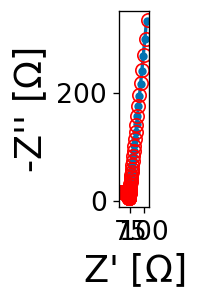

In [431]:
guesser(masked_mpt)

No handles with labels found to put in legend.


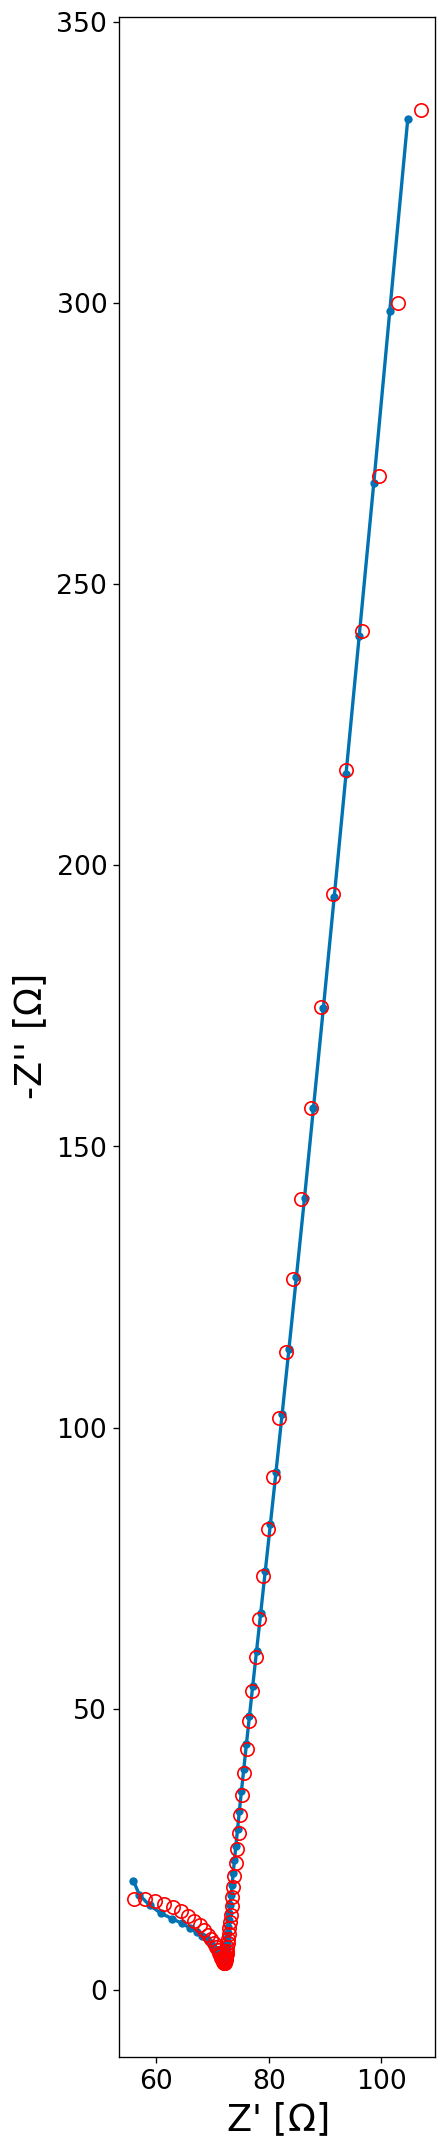

In [432]:
masked_mpt.set_new_gph_dims(50,50)
masked_mpt.mpt_plot(fitting = 'on')